## Setup and Installation

In [ ]:
# Install required packages
!pip install gymnasium[mujoco]
!pip install torch torchvision
!pip install numpy matplotlib pandas seaborn
!pip install tensorboard tqdm
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import time
import pandas as pd
from tqdm import tqdm
import os
import pickle
import random
import optuna


# random seeds
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Gymnasium version: {gym.__version__}")

Using device: cpu
PyTorch version: 2.9.0+cu126
Gymnasium version: 1.2.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Environment Setup and Analysis

In [ ]:
env = gym.make('HumanoidStandup-v5', render_mode="rgb_array")

print("Environment Information:")
print(f"Observation space: {env.observation_space}")
print(f"Observation shape: {env.observation_space.shape}")
print(f"Action space: {env.action_space}")
print(f"Action shape: {env.action_space.shape}")

low = env.action_space.low[0]
high = env.action_space.high[0]
print(f"Action bounds: [{low:.2f}, {high:.2f}]")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = float(high)

print(f"\nState dimension: {state_dim}")
print(f"Action dimension: {action_dim}")
print(f"Action bound: {action_bound}")

# env.close()

Environment Information:
Observation space: Box(-inf, inf, (348,), float64)
Observation shape: (348,)
Action space: Box(-0.4, 0.4, (17,), float32)
Action shape: (17,)
Action bounds: [-0.40, 0.40]

State dimension: 348
Action dimension: 17
Action bound: 0.4000000059604645


##  SAC Neural Network Architectures

SAC requires three types of networks:
1. **Actor Network**: Outputs mean and log_std for Gaussian policy
2. **Critic Networks**: Two Q-networks (Q1 and Q2) for double Q-learning
3. **Target Networks**: Target versions of critics for stable learning

In [ ]:
LOG_STD_MIN = -20
LOG_STD_MAX = 2
EPSILON = 1e-6

class ActorNetwork(nn.Module):
    """SAC Actor with squashed Gaussian policy"""

    def __init__(self, state_dim, action_dim, hidden_sizes=[256, 256], action_bound=1.0, nonlinearity = F.relu):
        super(ActorNetwork, self).__init__()

        self.action_bound = action_bound

        self.nonlinearity = nonlinearity

        # Shared layers
        self.fc1 = nn.Linear(state_dim, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])

        # Mean and log_std heads
        self.mean = nn.Linear(hidden_sizes[1], action_dim)
        self.log_std = nn.Linear(hidden_sizes[1], action_dim)

    def forward(self, state):
        x = self.nonlinearity(self.fc1(state))
        x = self.nonlinearity(self.fc2(x))

        mean = self.mean(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, LOG_STD_MIN, LOG_STD_MAX)

        return mean, log_std

    def sample(self, state, deterministic=False):
        """Sample action with reparameterization trick"""
        mean, log_std = self.forward(state)
        std = log_std.exp()

        if deterministic:
            action = torch.tanh(mean) * self.action_bound
            return action, None

        # Reparameterization trick
        normal = Normal(mean, std)
        x_t = normal.rsample()

        # Apply tanh squashing
        y_t = torch.tanh(x_t)
        action = y_t * self.action_bound

        # Calculate log probability
        log_prob = normal.log_prob(x_t)

        # Enforce Action Bound:
        log_prob -= torch.log(self.action_bound * (1 - y_t.pow(2)) + EPSILON)

        # Sum log probs across action dimensions
        log_prob = log_prob.sum(dim=-1, keepdim=True)

        return action, log_prob


class CriticNetwork(nn.Module):
    """SAC Critic (Double Q-network)"""

    def __init__(self, state_dim, action_dim, hidden_sizes=[256, 256], nonlinearity = F.relu):
        super(CriticNetwork, self).__init__()

        self.nonlinearity = nonlinearity

        # Q1 network
        self.q1_fc1 = nn.Linear(state_dim + action_dim, hidden_sizes[0])
        self.q1_fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.q1_out = nn.Linear(hidden_sizes[1], 1)

        # Q2 network
        self.q2_fc1 = nn.Linear(state_dim + action_dim, hidden_sizes[0])
        self.q2_fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.q2_out = nn.Linear(hidden_sizes[1], 1)

    def forward(self, state, action):
        """Return both Q-values"""
        # Concatenate state and action
        x = torch.cat([state, action], dim=-1)

        # Q1
        q1 = self.nonlinearity(self.q1_fc1(x))
        q1 = self.nonlinearity(self.q1_fc2(q1))
        q1 = self.q1_out(q1)

        # Q2
        q2 = self.nonlinearity(self.q2_fc1(x))
        q2 = self.nonlinearity(self.q2_fc2(q2))
        q2 = self.q2_out(q2)

        return q1, q2

    def q1_forward(self, state, action):
        """Return only Q1 value (for actor update to save compute)"""
        x = torch.cat([state, action], dim=-1)
        q1 = self.nonlinearity(self.q1_fc1(x))
        q1 = self.nonlinearity(self.q1_fc2(q1))
        q1 = self.q1_out(q1)
        return q1


# Initialize Networks
actor = ActorNetwork(state_dim, action_dim, action_bound=action_bound).to(device)
critic = CriticNetwork(state_dim, action_dim).to(device)

# Target Critic
critic_target = CriticNetwork(state_dim, action_dim).to(device)
critic_target.load_state_dict(critic.state_dict())

print("Actor Network initialized.")
print("Critic Network initialized.")

Actor Network initialized.
Critic Network initialized.


##  Replay Buffer
SAC is off-policy and uses experience replay for sample efficiency.

In [ ]:
class ReplayBuffer:
    """Experience replay buffer for off-policy learning"""

    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0
        self.states = np.zeros((max_size, state_dim), dtype=np.float32)
        self.actions = np.zeros((max_size, action_dim), dtype=np.float32)
        self.next_states = np.zeros((max_size, state_dim), dtype=np.float32)
        self.rewards = np.zeros((max_size, 1), dtype=np.float32)
        self.dones = np.zeros((max_size, 1), dtype=np.float32)

    def store(self, state, action, next_state, reward, done):
        """Store transition in buffer"""

        self.states[self.ptr] = np.array(state).flatten()
        self.actions[self.ptr] = action
        self.next_states[self.ptr] = np.array(next_state).flatten()
        self.rewards[self.ptr] = reward
        self.dones[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        """Sample random batch"""
        indices = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.states[indices]).to(device),
            torch.FloatTensor(self.actions[indices]).to(device),
            torch.FloatTensor(self.next_states[indices]).to(device),
            torch.FloatTensor(self.rewards[indices]).to(device),
            torch.FloatTensor(self.dones[indices]).to(device)
        )

    def __len__(self):
        return self.size

# Create buffer
buffer = ReplayBuffer(state_dim, action_dim, max_size=int(1e6))

print(f"Replay buffer created with capacity: {buffer.max_size:,}")

Replay buffer created with capacity: 1,000,000


## SAC Agent Implementation

Complete SAC algorithm with:
- Double Q-learning
- Automatic entropy tuning
- Target networks with soft updates
- Clipped double Q-learning

In [ ]:
class SACAgent:
    """Soft Actor-Critic Agent"""

    def __init__(self, state_dim, action_dim, action_bound, config):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.config = config

        # Actor network
        self.actor = ActorNetwork(
            state_dim, action_dim,
            config['hidden_sizes'],
            action_bound,
            config['nonlinearity']
        ).to(device)
        self.actor_optimizer = optim.Adam(
            self.actor.parameters(),
            lr=config['actor_lr']
        )

        # Critic networks
        self.critic = CriticNetwork(
            state_dim, action_dim,
            config['hidden_sizes'],
            config['nonlinearity']
        ).to(device)

        self.critic_target = CriticNetwork(
            state_dim, action_dim,
            config['hidden_sizes'],
            config['nonlinearity']
        ).to(device)

        self.critic_target.load_state_dict(self.critic.state_dict())

        self.critic_optimizer = optim.Adam(
            self.critic.parameters(),
            lr=config['critic_lr']
        )

        # Automatic entropy tuning
        self.target_entropy = -action_dim
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=config['alpha_lr'])

        # Replay buffer
        self.buffer = ReplayBuffer(state_dim, action_dim, config['buffer_size'])

        # Hyperparameters
        self.gamma = config['gamma']
        self.tau = config['tau']
        self.batch_size = config['batch_size']
        self.warmup_steps = config['warmup_steps']

        self.total_steps = 0

    @property
    def alpha(self):
        """Temperature parameter"""
        return self.log_alpha.exp()

    def select_action(self, state, deterministic=False):
        """Select action from policy"""
        with torch.no_grad():
            if isinstance(state, np.ndarray):
                state_tensor = torch.FloatTensor(state).to(device)
            else:
                state_tensor = torch.FloatTensor(np.array(state)).to(device)

            if state_tensor.dim() == 1:
                state_tensor = state_tensor.unsqueeze(0)

            action, _ = self.actor.sample(state_tensor, deterministic)

        return action.cpu().numpy()[0]

    def update(self):
        """Update networks using SAC"""
        if len(self.buffer) < self.batch_size:
            return {}

        # Sample batch
        states, actions, next_states, rewards, dones = self.buffer.sample(self.batch_size)

        # Update Critic
        with torch.no_grad():
            # Sample actions from current policy
            next_actions, next_log_probs = self.actor.sample(next_states)

            # Compute target Q-values
            q1_target, q2_target = self.critic_target(next_states, next_actions)
            q_target = torch.min(q1_target, q2_target)

            # Add entropy term
            q_target = q_target - self.alpha * next_log_probs

            # Compute TD target
            td_target = rewards + (1 - dones) * self.gamma * q_target

        # Get current Q estimates
        q1_current, q2_current = self.critic(states, actions)

        # Compute critic loss
        critic_loss = F.mse_loss(q1_current, td_target) + F.mse_loss(q2_current, td_target)

        # Update critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # Clip gradients for stability
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1.0)
        self.critic_optimizer.step()

        # Update Actor
        # Sample actions from current policy
        new_actions, log_probs = self.actor.sample(states)

        # Compute Q-values
        q1_new = self.critic.q1_forward(states, new_actions)

        # Actor loss (maximize Q - alpha * log_prob)
        actor_loss = (self.alpha * log_probs - q1_new).mean()

        # Update actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        # gradients
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1.0)
        self.actor_optimizer.step()

        # Update Temperature
        alpha_loss = -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()

        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()

        self.soft_update(self.critic, self.critic_target)

        return {
            'critic_loss': critic_loss.item(),
            'actor_loss': actor_loss.item(),
            'alpha_loss': alpha_loss.item(),
            'alpha': self.alpha.item(),
            'q1_mean': q1_current.mean().item(),
            'q2_mean': q2_current.mean().item()
        }

    def soft_update(self, source, target):
        """Soft update of target network"""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)

    def save(self, filename):
        torch.save({
            'actor': self.actor.state_dict(),
            'critic': self.critic.state_dict(),
            'log_alpha': self.log_alpha,
            'actor_opt': self.actor_optimizer.state_dict(),
            'critic_opt': self.critic_optimizer.state_dict(),
            'alpha_opt': self.alpha_optimizer.state_dict()
        }, filename)

    def load(self, filename):
        checkpoint = torch.load(filename, map_location=device)
        self.actor.load_state_dict(checkpoint['actor'])
        self.critic.load_state_dict(checkpoint['critic'])
        self.log_alpha = checkpoint['log_alpha']
        self.actor_optimizer.load_state_dict(checkpoint['actor_opt'])
        self.critic_optimizer.load_state_dict(checkpoint['critic_opt'])
        self.alpha_optimizer.load_state_dict(checkpoint['alpha_opt'])
        self.critic_target.load_state_dict(self.critic.state_dict())

print(" SAC Agent class defined successfully")

 SAC Agent class defined successfully


## Performance Metrics Tracker and Evaluation Agent

In [ ]:
class MetricsTracker:
    """Track and store performance metrics for SAC"""

    def __init__(self):
        self.episode_rewards = []
        self.episode_lengths = []
        self.actor_losses = []
        self.critic_losses = []
        self.alpha_values = []
        self.q_values = []
        self.eval_rewards = []
        self.eval_episodes = []
        self.training_times = []
        self.wall_clock_times = []
        self.buffer_sizes = []
        self.start_time = time.time()

    def record_episode(self, reward, length):
        self.episode_rewards.append(reward)
        self.episode_lengths.append(length)

    def record_training(self, stats):
        if 'actor_loss' in stats: self.actor_losses.append(stats['actor_loss'])
        if 'critic_loss' in stats: self.critic_losses.append(stats['critic_loss'])
        if 'alpha' in stats: self.alpha_values.append(stats['alpha'])
        if 'q1_mean' in stats: self.q_values.append(stats['q1_mean'])

    def record_evaluation(self, episode, mean_reward):
        self.eval_episodes.append(episode)
        self.eval_rewards.append(mean_reward)

    def record_time(self, episode_time):
        self.training_times.append(episode_time)
        self.wall_clock_times.append(time.time() - self.start_time)

    def record_buffer_size(self, size):
        self.buffer_sizes.append(size)

    def get_recent_stats(self, window=100):
        recent_rewards = self.episode_rewards[-window:]
        recent_lengths = self.episode_lengths[-window:]
        return {
            'mean_reward': np.mean(recent_rewards) if recent_rewards else 0,
            'mean_length': np.mean(recent_lengths) if recent_lengths else 0,
        }

    def to_dataframe(self):
        min_len = min(len(self.episode_rewards), len(self.episode_lengths))
        return pd.DataFrame({
            'episode': range(1, min_len + 1),
            'reward': self.episode_rewards[:min_len],
            'length': self.episode_lengths[:min_len],
        })

    def losses_to_dataframe(self):
        return pd.DataFrame({
            'actor_loss': self.actor_losses,
            'critic_loss': self.critic_losses,
            'alpha': self.alpha_values,
            'q_value': self.q_values
        })

def evaluate_agent(agent, env_name, num_episodes=5, seed=42):
    """
    Runs the agent deterministically.
    Args:
        agent: The SAC agent
        env_name: String name of the gym environment (e.g. 'HumanoidStandup-v5')
    """
    eval_env = gym.make(env_name)
    rewards = []

    for i in range(num_episodes):
        state, _ = eval_env.reset(seed=seed + i + 1000)
        episode_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.select_action(state, deterministic=True)
            next_state, reward, done, truncated, _ = eval_env.step(action)
            episode_reward += reward
            state = next_state

        rewards.append(episode_reward)

    eval_env.close()
    return np.mean(rewards), np.std(rewards)

print(" MetricsTracker and Evaluation Function defined.")

 MetricsTracker and Evaluation Function defined.


## Configuration and Hyperparameters

In [ ]:
config = {
    # Network architecture
    'hidden_sizes': [256, 256],
    'nonlinearity': F.relu,

    # Learning rates
    'actor_lr': 3e-4,
    'critic_lr': 3e-4,
    'alpha_lr': 3e-4,

    # SAC hyperparameters
    'gamma': 0.99,              # Discount factor
    'tau': 0.005,               # Soft update coefficient
    'batch_size': 256,          # Batch size for updates
    'buffer_size': int(1e6),    # Replay buffer size
    'warmup_steps': 10000,      # Random exploration steps

    # Training parameters
    'num_episodes': 500,       # Total episodes
    'max_steps': 1000,          # Max steps per episode
    'eval_episodes' : 5,
    'eval_frequency': 50,
}

print("SAC Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

SAC Configuration:
  hidden_sizes: [256, 256]
  nonlinearity: <function relu at 0x7bd957f70540>
  actor_lr: 0.0003
  critic_lr: 0.0003
  alpha_lr: 0.0003
  gamma: 0.99
  tau: 0.005
  batch_size: 256
  buffer_size: 1000000
  warmup_steps: 10000
  num_episodes: 500
  max_steps: 1000
  eval_episodes: 5
  eval_frequency: 50


## Training

In [ ]:
# Initialize
agent = SACAgent(state_dim, action_dim, action_bound, config)
tracker = MetricsTracker()
best_score = -float('inf')

print(f"Starting training on {device}")

for i_episode in tqdm(range(1, config['num_episodes'] + 1)):

    # Run Training Episode
    state, _ = env.reset(seed=SEED + i_episode)
    score = 0
    step_count = 0
    done = False

    while not done:
        step_count += 1

        if agent.total_steps < config['warmup_steps']:
            action = env.action_space.sample()
        else:
            action = agent.select_action(state)

        next_state, reward, term, trunc, _ = env.step(action)
        done = term or trunc
        mask = 1 if trunc else float(not done)

        agent.buffer.store(state, action, next_state, reward, mask)
        agent.total_steps += 1

        if agent.total_steps >= config['warmup_steps']:
            losses = agent.update()
            if losses:
                tracker.record_training(losses)

        state = next_state
        score += reward

        if step_count >= config['max_steps']:
            done = True

    # Record episode stats
    tracker.record_episode(score, step_count)

    # Evaluation Logic
    if i_episode % config['eval_frequency'] == 0:
        # unpack the tuple: (Mean, Std)
        avg_eval, std_eval = evaluate_agent(agent, 'HumanoidStandup-v5', num_episodes=config['eval_episodes'])

        tracker.record_evaluation(i_episode, avg_eval)

        if avg_eval > best_score:
            best_score = avg_eval
            agent.save("best_sac_humanoid.pth")

    # Logging
    if i_episode % 100 == 0:
        recent = tracker.get_recent_stats()
        print(f"Ep {i_episode} | Recent Avg: {recent['mean_reward']:.1f} | Best Eval: {best_score:.1f}")

print("Training Complete.")
agent.save("sac_humanoid.pth")

Starting training on cuda


 20%|██        | 100/500 [18:29<1:37:25, 14.61s/it]

Ep 100 | Recent Avg: 65631.2 | Best Eval: 87277.6


 40%|████      | 200/500 [38:42<1:09:13, 13.85s/it]

Ep 200 | Recent Avg: 69027.6 | Best Eval: 87277.6


 60%|██████    | 300/500 [58:43<46:53, 14.07s/it]

Ep 300 | Recent Avg: 63572.6 | Best Eval: 87277.6


 80%|████████  | 400/500 [1:18:37<23:02, 13.82s/it]

Ep 400 | Recent Avg: 70881.8 | Best Eval: 87277.6


100%|██████████| 500/500 [1:38:28<00:00, 11.82s/it]

Ep 500 | Recent Avg: 78241.0 | Best Eval: 125822.3
Training Complete.


## Visualize Results
Comprehensive visualization of SAC-specific metrics.

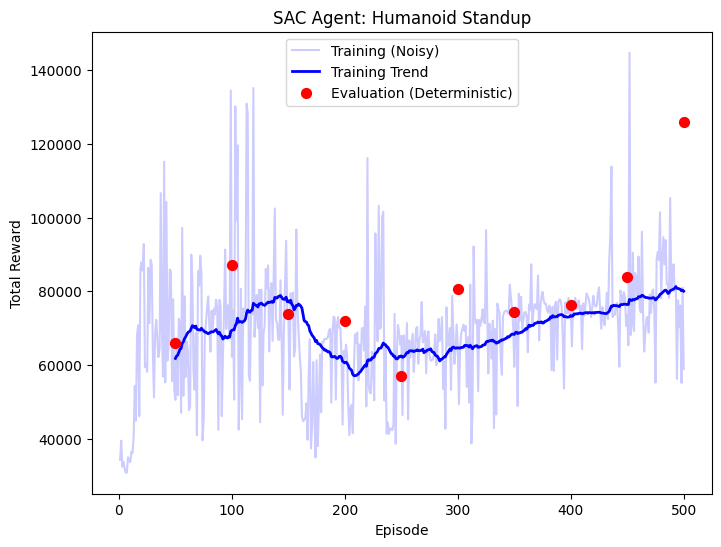

In [ ]:
df_ep = tracker.to_dataframe()

plt.figure(figsize=(8, 6))

# Raw training scores (Blue)
plt.plot(df_ep['episode'], df_ep['reward'],
         color='blue', alpha=0.2, label='Training (Noisy)')

# Moving average (Dark Blue)
plt.plot(df_ep['episode'], df_ep['reward'].rolling(window=50).mean(),
         color='blue', linewidth=2, label='Training Trend')

# Red Dots is the Real performance
if tracker.eval_episodes:
    plt.scatter(tracker.eval_episodes, tracker.eval_rewards, color='red', s=50, zorder=5, label='Evaluation (Deterministic)')

plt.title('SAC Agent: Humanoid Standup')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
#plt.grid(True, alpha=0.3)
plt.show()

### Episode Duration

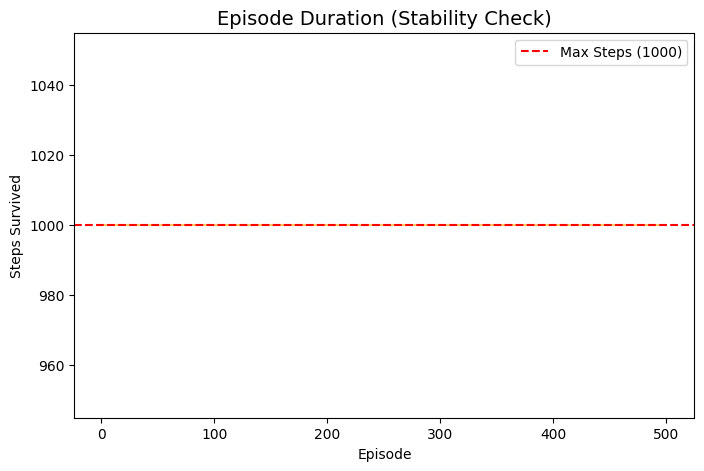

In [ ]:
plt.figure(figsize=(8, 5))
plt.title('Episode Duration (Stability Check)', fontsize=14)

sns.lineplot(x=df_ep['episode'], y=df_ep['length'], color='orange', alpha=0.6)

plt.axhline(y=config['max_steps'], color='r', linestyle='--', label=f"Max Steps ({config['max_steps']})")

plt.ylabel('Steps Survived')
plt.xlabel('Episode')
plt.legend()
plt.show()

### Alpha Decay

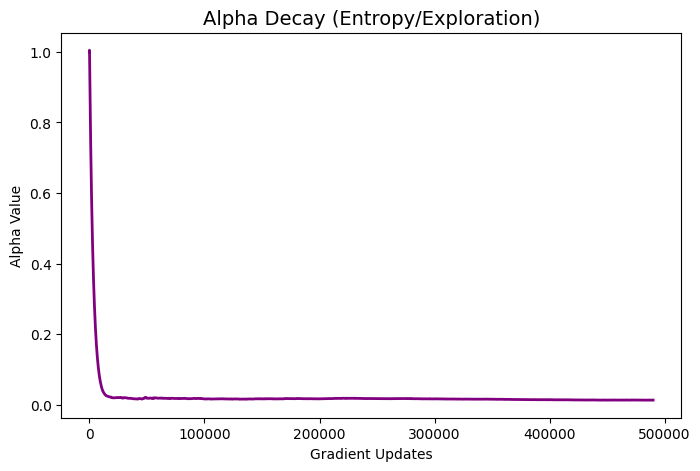

In [ ]:
alpha_vals = tracker.alpha_values if hasattr(tracker, 'alpha_values') else []

if alpha_vals:
    plt.figure(figsize=(8, 5))
    plt.title('Alpha Decay (Entropy/Exploration)', fontsize=14)

    plt.plot(alpha_vals, color='purple', linewidth=2)

    plt.ylabel('Alpha Value')
    plt.xlabel('Gradient Updates')
    #plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No Alpha data found in tracker.")

### Critic loss

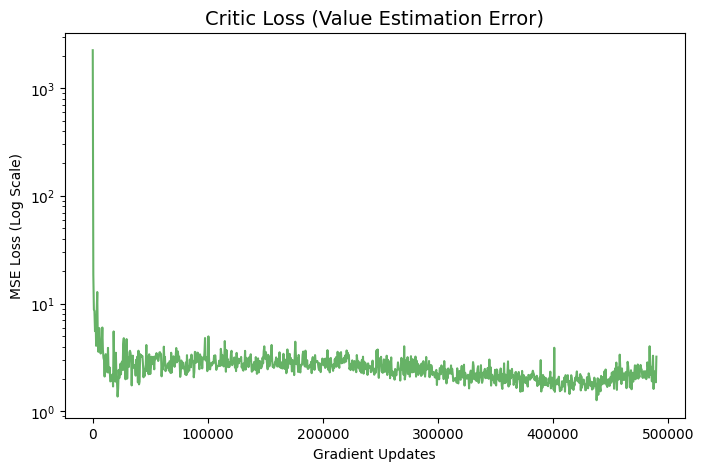

In [ ]:
critic_losses = tracker.critic_losses if hasattr(tracker, 'critic_losses') else []

if critic_losses:
    plt.figure(figsize=(8, 5))
    plt.title('Critic Loss (Value Estimation Error)', fontsize=14)

    indices = np.linspace(0, len(critic_losses)-1, min(1000, len(critic_losses))).astype(int)
    sampled_losses = np.array(critic_losses)[indices]

    plt.plot(indices, sampled_losses, color='green', alpha=0.6)

    plt.ylabel('MSE Loss (Log Scale)')
    plt.xlabel('Gradient Updates')
    plt.yscale('log')
    #plt.grid(True, alpha=0.3, which="both")
    plt.show()
else:
    print("No Critic Loss data found in tracker.")

## Save the model

In [ ]:
from google.colab import files
import os

filename = "best_sac_humanoid.pth"

if os.path.exists(filename):
    print(f"Downloading {filename}...")
    files.download(filename)
else:
    print(f"Error: '{filename}' not found.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## SAC humanoid Demo

In [ ]:
import os
print("Setting up virtual display...")
os.system('pip install pyvirtualdisplay > /dev/null 2>&1')
os.system('apt-get install -y xvfb > /dev/null 2>&1')

from pyvirtualdisplay import Display

display_screen = Display(visible=0, size=(1400, 900))
display_screen.start()
print("Virtual display started.")


os.environ['MUJOCO_GL'] = 'egl'

import imageio
import gymnasium as gym
from IPython.display import Video

def record_video_v5(agent, filename='humanoid_v5_victory.mp4', seed=42):

    print(f"Recording video to {filename} using HumanoidStandup-v5")

    agent.load("best_sac_humanoid.pth")

    env = gym.make('HumanoidStandup-v5', render_mode='rgb_array')

    state, _ = env.reset(seed=seed)

    frames = []
    done = False
    truncated = False
    step = 0

    while not (done or truncated):
        frames.append(env.render())

        action = agent.select_action(state, deterministic=True)

        state, _, done, truncated, _ = env.step(action)
        step += 1

    env.close()

    imageio.mimsave(filename, frames, fps=30)
    print(f"Video saved! ({len(frames)} frames, {step} steps)")
    return filename

# Run it
#video_file = record_video_v5(agent)

Setting up virtual display...
Virtual display started.


In [ ]:
if video_file:
    display(Video(video_file, embed=True, html_attributes="controls autoplay loop"))

## Hyperparameter Tuning

In [ ]:
config = {
    # Network architecture
    'hidden_sizes': [256, 256],
    'nonlinearity': F.relu,

    # Learning rates
    'actor_lr': 3e-4,
    'critic_lr': 3e-4,
    'alpha_lr': 3e-4,

    # SAC hyperparameters
    'gamma': 0.99,              # Discount factor
    'tau': 0.005,               # Soft update coefficient
    'batch_size': 256,          # Batch size for updates
    'buffer_size': int(1e6),    # Replay buffer size
    'warmup_steps': 10000,      # Random exploration steps

    # Training parameters
    'num_episodes': 1000,       # Total episodes
    'max_steps': 1000,          # Max steps per episode
    'eval_episodes' : 5,
    'eval_frequency': 50,
}

In [ ]:
def train_model(agent, tracker, best_score, save_path="sac_humanoid.pth"):
  print(f"Starting training on {device}")

  for i_episode in tqdm(range(1, config['num_episodes'] + 1)):

      # Run Training Episode
      state, _ = env.reset(seed=SEED + i_episode)
      score = 0
      step_count = 0
      done = False

      while not done:
          step_count += 1

          if agent.total_steps < config['warmup_steps']:
              action = env.action_space.sample()
          else:
              action = agent.select_action(state)

          next_state, reward, term, trunc, _ = env.step(action)
          done = term or trunc
          mask = 1 if trunc else float(not done)

          agent.buffer.store(state, action, next_state, reward, mask)
          agent.total_steps += 1

          if agent.total_steps >= config['warmup_steps']:
              losses = agent.update()
              if losses:
                  tracker.record_training(losses)

          state = next_state
          score += reward

          if step_count >= config['max_steps']:
              done = True

      # Record episode stats
      tracker.record_episode(score, step_count)

      # Evaluation Logic
      if i_episode % config['eval_frequency'] == 0:
          # unpack the tuple: (Mean, Std)
          avg_eval, std_eval = evaluate_agent(agent, 'HumanoidStandup-v5', num_episodes=config['eval_episodes'])

          tracker.record_evaluation(i_episode, avg_eval)

          if avg_eval > best_score:
              best_score = avg_eval
              agent.save("best_sac_humanoid.pth")

      # Logging
      if i_episode % 100 == 0:
          recent = tracker.get_recent_stats()
          print(f"Ep {i_episode} | Recent Avg: {recent['mean_reward']:.1f} | Best Eval: {best_score:.1f}")

  print("Training Complete.")
  agent.save(save_path)


In [ ]:
nonlinearities = [F.relu, torch.tanh, F.silu]
nonlinearity_names = ['relu', 'tanh', 'silu']

for i in range(3):

  config['nonlinearity'] = nonlinearities[i]

  tmp_agent = SACAgent(state_dim, action_dim, action_bound, config)
  tmp_tracker = MetricsTracker()
  best_score = -float('inf')
  train_model(tmp_agent, tmp_tracker, best_score, f'/content/drive/MyDrive/CMPE260Data/SACNonlinearitiesData/{nonlinearity_names[i]}.pth')
  tmp_df = tmp_tracker.to_dataframe()
  tmp_df.to_csv(f'/content/drive/MyDrive/CMPE260Data/SACNonlinearitiesData/{nonlinearity_names[i]}.csv')



Starting training on cuda


 10%|█         | 100/1000 [19:48<3:51:16, 15.42s/it]

Ep 100 | Recent Avg: 64332.1 | Best Eval: 66774.0


 20%|██        | 200/1000 [41:21<3:29:24, 15.71s/it]

Ep 200 | Recent Avg: 76437.4 | Best Eval: 77599.7


 30%|███       | 300/1000 [1:02:45<2:55:58, 15.08s/it]

Ep 300 | Recent Avg: 81854.4 | Best Eval: 80441.8


 40%|████      | 400/1000 [1:24:14<2:31:52, 15.19s/it]

Ep 400 | Recent Avg: 60775.6 | Best Eval: 80441.8


 50%|█████     | 500/1000 [1:45:40<2:04:02, 14.88s/it]

Ep 500 | Recent Avg: 60671.0 | Best Eval: 80441.8


 60%|██████    | 600/1000 [2:06:56<1:40:24, 15.06s/it]

Ep 600 | Recent Avg: 62195.6 | Best Eval: 80441.8


 70%|███████   | 700/1000 [2:27:55<1:14:36, 14.92s/it]

Ep 700 | Recent Avg: 74518.3 | Best Eval: 80441.8


 80%|████████  | 800/1000 [2:48:59<49:20, 14.80s/it]

Ep 800 | Recent Avg: 71159.4 | Best Eval: 80441.8


 90%|█████████ | 900/1000 [3:10:02<24:25, 14.65s/it]

Ep 900 | Recent Avg: 72070.1 | Best Eval: 80441.8


100%|██████████| 1000/1000 [3:30:54<00:00, 12.65s/it]

Ep 1000 | Recent Avg: 76577.2 | Best Eval: 80441.8
Training Complete.


Starting training on cuda


 10%|█         | 100/1000 [19:12<3:50:16, 15.35s/it]

Ep 100 | Recent Avg: 49187.5 | Best Eval: 44564.5


 20%|██        | 200/1000 [40:19<3:25:53, 15.44s/it]

Ep 200 | Recent Avg: 47551.6 | Best Eval: 47112.7


 30%|███       | 300/1000 [1:01:48<3:00:09, 15.44s/it]

Ep 300 | Recent Avg: 44679.2 | Best Eval: 47112.7


 40%|████      | 400/1000 [1:23:15<2:33:08, 15.31s/it]

Ep 400 | Recent Avg: 49707.8 | Best Eval: 81172.3


 50%|█████     | 500/1000 [1:44:44<2:05:55, 15.11s/it]

Ep 500 | Recent Avg: 45060.5 | Best Eval: 81172.3


 60%|██████    | 600/1000 [2:06:18<1:42:51, 15.43s/it]

Ep 600 | Recent Avg: 42483.9 | Best Eval: 81172.3


 70%|███████   | 700/1000 [2:27:42<1:15:41, 15.14s/it]

Ep 700 | Recent Avg: 44428.8 | Best Eval: 81172.3


 80%|████████  | 800/1000 [2:49:08<50:07, 15.04s/it]

Ep 800 | Recent Avg: 47500.8 | Best Eval: 81172.3


 90%|█████████ | 900/1000 [3:10:41<25:50, 15.51s/it]

Ep 900 | Recent Avg: 51499.8 | Best Eval: 81172.3


100%|██████████| 1000/1000 [3:32:02<00:00, 12.72s/it]

Ep 1000 | Recent Avg: 48257.9 | Best Eval: 81172.3
Training Complete.


Starting training on cuda


 10%|█         | 100/1000 [19:14<3:49:10, 15.28s/it]

Ep 100 | Recent Avg: 59786.6 | Best Eval: 64603.4


 20%|██        | 200/1000 [40:29<3:21:56, 15.15s/it]

Ep 200 | Recent Avg: 53987.2 | Best Eval: 64603.4


 30%|███       | 300/1000 [1:01:45<2:54:06, 14.92s/it]

Ep 300 | Recent Avg: 49398.9 | Best Eval: 64603.4


 40%|████      | 400/1000 [1:23:12<2:31:35, 15.16s/it]

Ep 400 | Recent Avg: 52362.7 | Best Eval: 70867.1


 50%|█████     | 500/1000 [1:44:26<2:07:08, 15.26s/it]

Ep 500 | Recent Avg: 70876.3 | Best Eval: 78203.6


 60%|██████    | 600/1000 [2:05:34<1:40:59, 15.15s/it]

Ep 600 | Recent Avg: 67630.5 | Best Eval: 78203.6


 70%|███████   | 700/1000 [2:26:43<1:14:23, 14.88s/it]

Ep 700 | Recent Avg: 74723.6 | Best Eval: 78203.6


 80%|████████  | 800/1000 [2:47:49<50:13, 15.07s/it]

Ep 800 | Recent Avg: 78377.9 | Best Eval: 78203.6


 90%|█████████ | 900/1000 [3:08:42<24:20, 14.61s/it]

Ep 900 | Recent Avg: 75285.9 | Best Eval: 86736.2


100%|██████████| 1000/1000 [3:29:34<00:00, 12.57s/it]

Ep 1000 | Recent Avg: 74236.1 | Best Eval: 86736.2
Training Complete.


In [ ]:
relu_df = pd.read_csv('/content/drive/MyDrive/CMPE260Data/SACNonlinearitiesData/relu.csv')
tanh_df = pd.read_csv('/content/drive/MyDrive/CMPE260Data/SACNonlinearitiesData/tanh.csv')
silu_df = pd.read_csv('/content/drive/MyDrive/CMPE260Data/SACNonlinearitiesData/silu.csv')

In [ ]:
relu_df.columns

Index(['Unnamed: 0', 'episode', 'reward', 'length'], dtype='object')

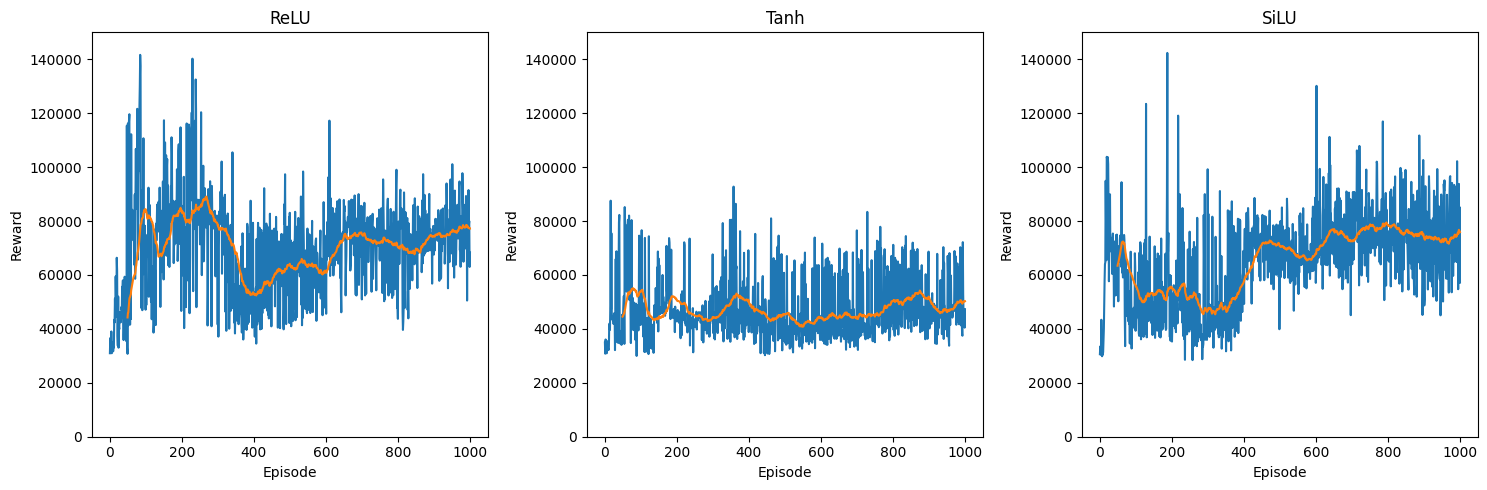

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

axes[0].plot(relu_df['episode'], relu_df['reward'])
axes[0].plot(relu_df['episode'], relu_df['reward'].rolling(window=50).mean())
axes[0].set_ylabel('Reward')
axes[0].set_xlabel('Episode')
axes[0].set_title('ReLU')
axes[0].set_ylim(0, 150000)

axes[1].plot(tanh_df['episode'], tanh_df['reward'])
axes[1].plot(tanh_df['episode'], tanh_df['reward'].rolling(window=50).mean())
axes[1].set_ylabel('Reward')
axes[1].set_xlabel('Episode')
axes[1].set_title('Tanh')
axes[1].set_ylim(0, 150000)

axes[2].plot(silu_df['episode'], silu_df['reward'])
axes[2].plot(silu_df['episode'], silu_df['reward'].rolling(window=50).mean())
axes[2].set_ylabel('Reward')
axes[2].set_xlabel('Episode')
axes[2].set_title('SiLU')
axes[2].set_ylim(0, 150000)

plt.tight_layout()
plt.show()

Both Relu and Silu had similar performance, and Tanh performed much worse

In [ ]:
best_nonlinearity = F.silu
config['nonlinearity'] = best_nonlinearity

In [ ]:
hidden_sizes = [[128, 128], [256, 256], [512, 512]]

for i in range(3):

  config['hidden_sizes'] = hidden_sizes[i]

  tmp_agent = SACAgent(state_dim, action_dim, action_bound, config)
  tmp_tracker = MetricsTracker()
  best_score = -float('inf')
  train_model(tmp_agent, tmp_tracker, best_score, f'/content/drive/MyDrive/CMPE260Data/HiddenSizes/{hidden_sizes[i][0]}.pth')
  tmp_df = tmp_tracker.to_dataframe()
  tmp_df.to_csv(f'/content/drive/MyDrive/CMPE260Data/HiddenSizes/{hidden_sizes[i][0]}.csv')




Starting training on cuda


 10%|█         | 100/1000 [18:08<3:33:55, 14.26s/it]

Ep 100 | Recent Avg: 66251.6 | Best Eval: 86571.2


 20%|██        | 200/1000 [38:06<3:02:54, 13.72s/it]

Ep 200 | Recent Avg: 62351.3 | Best Eval: 86571.2


 30%|███       | 300/1000 [58:10<2:43:57, 14.05s/it]

Ep 300 | Recent Avg: 64292.8 | Best Eval: 86571.2


 40%|████      | 400/1000 [1:18:04<2:17:53, 13.79s/it]

Ep 400 | Recent Avg: 65428.4 | Best Eval: 86571.2


 50%|█████     | 500/1000 [1:37:51<1:58:49, 14.26s/it]

Ep 500 | Recent Avg: 66192.4 | Best Eval: 86571.2


 60%|██████    | 600/1000 [1:57:49<1:32:57, 13.94s/it]

Ep 600 | Recent Avg: 69714.0 | Best Eval: 86571.2


 70%|███████   | 700/1000 [2:17:48<1:09:39, 13.93s/it]

Ep 700 | Recent Avg: 70794.3 | Best Eval: 92986.1


 80%|████████  | 800/1000 [2:37:41<46:04, 13.82s/it]

Ep 800 | Recent Avg: 70651.2 | Best Eval: 92986.1


 90%|█████████ | 900/1000 [2:57:46<23:27, 14.08s/it]

Ep 900 | Recent Avg: 63345.2 | Best Eval: 92986.1


100%|██████████| 1000/1000 [3:17:54<00:00, 11.87s/it]

Ep 1000 | Recent Avg: 58182.9 | Best Eval: 92986.1
Training Complete.


Starting training on cuda


 10%|█         | 100/1000 [18:27<3:33:55, 14.26s/it]

Ep 100 | Recent Avg: 61349.4 | Best Eval: 62757.9


 20%|██        | 200/1000 [38:51<3:12:14, 14.42s/it]

Ep 200 | Recent Avg: 47080.7 | Best Eval: 62757.9


 30%|███       | 300/1000 [59:13<2:51:08, 14.67s/it]

Ep 300 | Recent Avg: 45709.5 | Best Eval: 62757.9


 40%|████      | 400/1000 [1:19:13<2:17:18, 13.73s/it]

Ep 400 | Recent Avg: 67126.1 | Best Eval: 100471.5


 50%|█████     | 500/1000 [1:39:10<1:57:24, 14.09s/it]

Ep 500 | Recent Avg: 79181.0 | Best Eval: 100471.5


 60%|██████    | 600/1000 [1:59:01<1:33:18, 14.00s/it]

Ep 600 | Recent Avg: 75506.9 | Best Eval: 100471.5


 70%|███████   | 700/1000 [2:18:52<1:09:37, 13.92s/it]

Ep 700 | Recent Avg: 75028.7 | Best Eval: 100471.5


 80%|████████  | 800/1000 [2:38:43<46:01, 13.81s/it]

Ep 800 | Recent Avg: 71325.5 | Best Eval: 100471.5


 90%|█████████ | 900/1000 [2:58:52<24:39, 14.80s/it]

Ep 900 | Recent Avg: 65733.9 | Best Eval: 100471.5


100%|██████████| 1000/1000 [3:20:22<00:00, 12.02s/it]

Ep 1000 | Recent Avg: 63560.7 | Best Eval: 100471.5
Training Complete.


Starting training on cuda


 10%|█         | 100/1000 [20:28<4:04:05, 16.27s/it]

Ep 100 | Recent Avg: 65198.3 | Best Eval: 47513.1


 20%|██        | 200/1000 [41:43<3:22:41, 15.20s/it]

Ep 200 | Recent Avg: 56615.6 | Best Eval: 56535.8


 30%|███       | 300/1000 [1:03:27<2:58:46, 15.32s/it]

Ep 300 | Recent Avg: 46610.7 | Best Eval: 61894.5


 40%|████      | 400/1000 [1:25:39<2:32:28, 15.25s/it]

Ep 400 | Recent Avg: 60320.0 | Best Eval: 64711.4


 50%|█████     | 500/1000 [1:46:53<1:57:00, 14.04s/it]

Ep 500 | Recent Avg: 70029.9 | Best Eval: 76334.4


 60%|██████    | 600/1000 [2:06:57<1:35:06, 14.27s/it]

Ep 600 | Recent Avg: 77861.1 | Best Eval: 89031.1


 70%|███████   | 700/1000 [2:26:54<1:09:08, 13.83s/it]

Ep 700 | Recent Avg: 81056.9 | Best Eval: 95625.4


 80%|████████  | 800/1000 [2:46:56<46:25, 13.93s/it]

Ep 800 | Recent Avg: 80224.4 | Best Eval: 95625.4


 90%|█████████ | 900/1000 [3:06:54<23:39, 14.19s/it]

Ep 900 | Recent Avg: 76248.2 | Best Eval: 95625.4


100%|██████████| 1000/1000 [3:27:04<00:00, 12.42s/it]

Ep 1000 | Recent Avg: 73693.5 | Best Eval: 95625.4
Training Complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
config['hidden_sizes'] = [512,512]
config['num_episodes'] = 3000
tmp_agent = SACAgent(state_dim, action_dim, action_bound, config)
tmp_tracker = MetricsTracker()
best_score = -float('inf')

train_model(tmp_agent, tmp_tracker, best_score, f'/content/drive/MyDrive/CMPE260Data/test_model.pth')
tmp_df = tmp_tracker.to_dataframe()
tmp_df.to_csv(f'/content/drive/MyDrive/CMPE260Data/test_model_data.csv')


Starting training on cuda


  3%|▎         | 100/3000 [18:43<11:41:28, 14.51s/it]

Ep 100 | Recent Avg: 69091.2 | Best Eval: 125980.7


  7%|▋         | 200/3000 [39:29<11:40:50, 15.02s/it]

Ep 200 | Recent Avg: 85142.2 | Best Eval: 125980.7


 10%|█         | 300/3000 [1:00:14<11:23:35, 15.19s/it]

Ep 300 | Recent Avg: 87420.1 | Best Eval: 134657.8


 13%|█▎        | 400/3000 [1:21:07<11:49:32, 16.37s/it]

Ep 400 | Recent Avg: 64185.7 | Best Eval: 134657.8


 17%|█▋        | 500/3000 [1:44:02<9:59:38, 14.39s/it]

Ep 500 | Recent Avg: 44520.0 | Best Eval: 134657.8


 20%|██        | 600/3000 [2:04:44<9:34:34, 14.36s/it]

Ep 600 | Recent Avg: 58498.4 | Best Eval: 134657.8


 23%|██▎       | 700/3000 [2:25:22<9:11:48, 14.39s/it]

Ep 700 | Recent Avg: 59030.9 | Best Eval: 134657.8


 27%|██▋       | 800/3000 [2:45:48<8:44:33, 14.31s/it]

Ep 800 | Recent Avg: 64800.1 | Best Eval: 134657.8


 30%|███       | 900/3000 [3:06:02<8:18:17, 14.24s/it]

Ep 900 | Recent Avg: 74842.4 | Best Eval: 134657.8


 33%|███▎      | 1000/3000 [3:26:14<8:04:39, 14.54s/it]

Ep 1000 | Recent Avg: 74327.2 | Best Eval: 134657.8


 37%|███▋      | 1100/3000 [3:46:21<7:23:35, 14.01s/it]

Ep 1100 | Recent Avg: 75253.3 | Best Eval: 134657.8


 40%|████      | 1200/3000 [4:06:24<6:58:45, 13.96s/it]

Ep 1200 | Recent Avg: 74429.4 | Best Eval: 134657.8


 43%|████▎     | 1300/3000 [4:26:26<6:32:49, 13.86s/it]

Ep 1300 | Recent Avg: 79907.5 | Best Eval: 134657.8


 47%|████▋     | 1400/3000 [4:46:35<6:16:41, 14.13s/it]

Ep 1400 | Recent Avg: 83581.1 | Best Eval: 134657.8


 50%|█████     | 1500/3000 [5:07:08<6:11:12, 14.85s/it]

Ep 1500 | Recent Avg: 80033.6 | Best Eval: 134657.8


 53%|█████▎    | 1600/3000 [5:27:51<5:43:48, 14.73s/it]

Ep 1600 | Recent Avg: 77457.5 | Best Eval: 134657.8


 57%|█████▋    | 1700/3000 [5:48:57<5:14:54, 14.53s/it]

Ep 1700 | Recent Avg: 78085.8 | Best Eval: 134657.8


 60%|██████    | 1800/3000 [6:09:42<4:45:28, 14.27s/it]

Ep 1800 | Recent Avg: 78125.3 | Best Eval: 134657.8


 63%|██████▎   | 1900/3000 [6:30:33<4:27:56, 14.62s/it]

Ep 1900 | Recent Avg: 77809.5 | Best Eval: 134657.8


 67%|██████▋   | 2000/3000 [6:51:15<3:57:55, 14.28s/it]

Ep 2000 | Recent Avg: 72697.4 | Best Eval: 134657.8


 70%|███████   | 2100/3000 [7:12:02<3:37:30, 14.50s/it]

Ep 2100 | Recent Avg: 68998.7 | Best Eval: 134657.8


 73%|███████▎  | 2200/3000 [7:32:48<3:14:30, 14.59s/it]

Ep 2200 | Recent Avg: 70125.2 | Best Eval: 134657.8


 77%|███████▋  | 2300/3000 [7:53:33<2:48:21, 14.43s/it]

Ep 2300 | Recent Avg: 68576.3 | Best Eval: 134657.8


 80%|████████  | 2400/3000 [8:14:16<2:30:54, 15.09s/it]

Ep 2400 | Recent Avg: 67474.9 | Best Eval: 134657.8


 83%|████████▎ | 2500/3000 [8:35:02<2:01:03, 14.53s/it]

Ep 2500 | Recent Avg: 74272.3 | Best Eval: 134657.8


 87%|████████▋ | 2600/3000 [8:55:52<1:36:08, 14.42s/it]

Ep 2600 | Recent Avg: 73404.5 | Best Eval: 134657.8


 90%|█████████ | 2700/3000 [9:16:39<1:13:24, 14.68s/it]

Ep 2700 | Recent Avg: 72617.9 | Best Eval: 134657.8


 93%|█████████▎| 2800/3000 [9:37:19<47:51, 14.36s/it]

Ep 2800 | Recent Avg: 68367.2 | Best Eval: 134657.8


 97%|█████████▋| 2900/3000 [9:57:45<23:59, 14.39s/it]

Ep 2900 | Recent Avg: 69583.9 | Best Eval: 134657.8


100%|██████████| 3000/3000 [10:18:02<00:00, 12.36s/it]

Ep 3000 | Recent Avg: 71422.9 | Best Eval: 134657.8
Training Complete.


In [ ]:
config['num_episodes'] = 10000
config['max_steps'] = 200
config['hidden_sizes'] = [512,512]
config['gamma'] = 0.995

tmp_agent = SACAgent(state_dim, action_dim, action_bound, config)
tmp_tracker = MetricsTracker()
best_score = -float('inf')

train_model(tmp_agent, tmp_tracker, best_score, f'/content/drive/MyDrive/CMPE260Data/test2_model.pth')
tmp_df = tmp_tracker.to_dataframe()
tmp_df.to_csv(f'/content/drive/MyDrive/CMPE260Data/test2_model_data.csv')


Starting training on cuda


  1%|          | 100/10000 [02:26<13:08:06,  4.78s/it]

Ep 100 | Recent Avg: 10520.9 | Best Eval: 63530.6


  2%|▏         | 200/10000 [06:56<15:12:03,  5.58s/it]

Ep 200 | Recent Avg: 17941.8 | Best Eval: 64018.6


  3%|▎         | 300/10000 [11:23<13:46:10,  5.11s/it]

Ep 300 | Recent Avg: 20673.3 | Best Eval: 80163.1


  4%|▍         | 400/10000 [15:49<13:10:51,  4.94s/it]

Ep 400 | Recent Avg: 19777.5 | Best Eval: 80163.1


  5%|▌         | 500/10000 [20:15<13:30:16,  5.12s/it]

Ep 500 | Recent Avg: 18824.7 | Best Eval: 85619.9


  6%|▌         | 600/10000 [24:35<13:00:00,  4.98s/it]

Ep 600 | Recent Avg: 17484.3 | Best Eval: 85619.9


  7%|▋         | 700/10000 [28:58<12:37:53,  4.89s/it]

Ep 700 | Recent Avg: 18325.8 | Best Eval: 85619.9


  8%|▊         | 800/10000 [33:17<13:05:38,  5.12s/it]

Ep 800 | Recent Avg: 18359.4 | Best Eval: 85619.9


  9%|▉         | 900/10000 [37:39<13:33:53,  5.37s/it]

Ep 900 | Recent Avg: 19637.8 | Best Eval: 85619.9


 10%|█         | 1000/10000 [42:00<12:18:16,  4.92s/it]

Ep 1000 | Recent Avg: 20922.7 | Best Eval: 85619.9


 11%|█         | 1100/10000 [46:19<11:50:15,  4.79s/it]

Ep 1100 | Recent Avg: 17709.3 | Best Eval: 85619.9


 12%|█▏        | 1200/10000 [50:38<12:03:54,  4.94s/it]

Ep 1200 | Recent Avg: 10362.1 | Best Eval: 85619.9


 13%|█▎        | 1300/10000 [54:57<11:42:32,  4.85s/it]

Ep 1300 | Recent Avg: 11532.3 | Best Eval: 85619.9


 14%|█▍        | 1400/10000 [59:19<11:28:39,  4.80s/it]

Ep 1400 | Recent Avg: 12459.4 | Best Eval: 85619.9


 15%|█▌        | 1500/10000 [1:03:38<11:00:50,  4.66s/it]

Ep 1500 | Recent Avg: 12640.4 | Best Eval: 85619.9


 16%|█▌        | 1600/10000 [1:07:55<11:38:57,  4.99s/it]

Ep 1600 | Recent Avg: 11728.6 | Best Eval: 85619.9


 17%|█▋        | 1700/10000 [1:12:12<11:13:20,  4.87s/it]

Ep 1700 | Recent Avg: 11350.5 | Best Eval: 85619.9


 18%|█▊        | 1800/10000 [1:16:32<11:43:49,  5.15s/it]

Ep 1800 | Recent Avg: 10768.4 | Best Eval: 85619.9


 19%|█▉        | 1900/10000 [1:20:50<11:21:46,  5.05s/it]

Ep 1900 | Recent Avg: 11686.5 | Best Eval: 85619.9


 20%|██        | 2000/10000 [1:25:10<11:03:54,  4.98s/it]

Ep 2000 | Recent Avg: 12244.2 | Best Eval: 85619.9


 21%|██        | 2100/10000 [1:29:30<11:45:02,  5.35s/it]

Ep 2100 | Recent Avg: 12347.1 | Best Eval: 85619.9


 22%|██▏       | 2200/10000 [1:33:51<10:46:17,  4.97s/it]

Ep 2200 | Recent Avg: 12778.9 | Best Eval: 85619.9


 23%|██▎       | 2300/10000 [1:38:13<10:37:54,  4.97s/it]

Ep 2300 | Recent Avg: 12436.0 | Best Eval: 85619.9


 24%|██▍       | 2400/10000 [1:42:33<10:30:57,  4.98s/it]

Ep 2400 | Recent Avg: 12423.2 | Best Eval: 85619.9


 25%|██▌       | 2500/10000 [1:46:54<10:22:56,  4.98s/it]

Ep 2500 | Recent Avg: 12716.5 | Best Eval: 85619.9


 26%|██▌       | 2600/10000 [1:51:15<10:10:56,  4.95s/it]

Ep 2600 | Recent Avg: 12540.4 | Best Eval: 85619.9


 27%|██▋       | 2700/10000 [1:55:36<10:37:15,  5.24s/it]

Ep 2700 | Recent Avg: 13011.1 | Best Eval: 85619.9


 28%|██▊       | 2800/10000 [1:59:56<9:38:22,  4.82s/it]

Ep 2800 | Recent Avg: 13622.1 | Best Eval: 85619.9


 29%|██▉       | 2900/10000 [2:04:12<8:48:33,  4.47s/it]

Ep 2900 | Recent Avg: 14691.6 | Best Eval: 116988.0


 30%|███       | 3000/10000 [2:08:31<9:20:59,  4.81s/it]

Ep 3000 | Recent Avg: 16019.4 | Best Eval: 116988.0


 31%|███       | 3100/10000 [2:12:48<8:46:43,  4.58s/it]

Ep 3100 | Recent Avg: 16581.1 | Best Eval: 116988.0


 32%|███▏      | 3200/10000 [2:17:03<8:43:36,  4.62s/it]

Ep 3200 | Recent Avg: 16685.4 | Best Eval: 116988.0


 33%|███▎      | 3300/10000 [2:21:18<8:29:50,  4.57s/it]

Ep 3300 | Recent Avg: 14553.2 | Best Eval: 116988.0


 34%|███▍      | 3400/10000 [2:25:32<8:46:53,  4.79s/it]

Ep 3400 | Recent Avg: 15917.2 | Best Eval: 116988.0


 35%|███▌      | 3500/10000 [2:29:49<8:53:41,  4.93s/it]

Ep 3500 | Recent Avg: 14634.6 | Best Eval: 116988.0


 36%|███▌      | 3600/10000 [2:34:04<8:31:20,  4.79s/it]

Ep 3600 | Recent Avg: 14772.6 | Best Eval: 116988.0


 37%|███▋      | 3700/10000 [2:38:18<8:15:38,  4.72s/it]

Ep 3700 | Recent Avg: 14599.4 | Best Eval: 116988.0


 38%|███▊      | 3800/10000 [2:42:32<7:59:17,  4.64s/it]

Ep 3800 | Recent Avg: 16475.5 | Best Eval: 116988.0


 39%|███▉      | 3900/10000 [2:46:48<8:15:00,  4.87s/it]

Ep 3900 | Recent Avg: 16340.2 | Best Eval: 116988.0


 40%|████      | 4000/10000 [2:51:02<7:46:18,  4.66s/it]

Ep 4000 | Recent Avg: 17907.2 | Best Eval: 116988.0


 41%|████      | 4100/10000 [2:55:17<8:15:31,  5.04s/it]

Ep 4100 | Recent Avg: 16559.4 | Best Eval: 116988.0


 42%|████▏     | 4200/10000 [2:59:32<7:35:04,  4.71s/it]

Ep 4200 | Recent Avg: 17242.5 | Best Eval: 116988.0


 43%|████▎     | 4300/10000 [3:03:59<7:42:49,  4.87s/it]

Ep 4300 | Recent Avg: 17935.2 | Best Eval: 116988.0


 44%|████▍     | 4400/10000 [3:08:21<7:18:05,  4.69s/it]

Ep 4400 | Recent Avg: 19516.9 | Best Eval: 116988.0


 45%|████▌     | 4500/10000 [3:12:44<7:06:43,  4.66s/it]

Ep 4500 | Recent Avg: 19693.8 | Best Eval: 116988.0


 46%|████▌     | 4600/10000 [3:17:08<7:10:03,  4.78s/it]

Ep 4600 | Recent Avg: 20852.6 | Best Eval: 116988.0


 47%|████▋     | 4700/10000 [3:21:31<7:18:39,  4.97s/it]

Ep 4700 | Recent Avg: 20094.4 | Best Eval: 116988.0


 48%|████▊     | 4800/10000 [3:25:44<6:43:11,  4.65s/it]

Ep 4800 | Recent Avg: 20745.8 | Best Eval: 116988.0


 49%|████▉     | 4900/10000 [3:29:56<6:19:32,  4.47s/it]

Ep 4900 | Recent Avg: 20829.9 | Best Eval: 126627.9


 50%|█████     | 5000/10000 [3:34:13<6:40:20,  4.80s/it]

Ep 5000 | Recent Avg: 22195.4 | Best Eval: 126627.9


 51%|█████     | 5100/10000 [3:38:30<6:28:26,  4.76s/it]

Ep 5100 | Recent Avg: 21883.7 | Best Eval: 126627.9


 52%|█████▏    | 5200/10000 [3:42:46<6:36:32,  4.96s/it]

Ep 5200 | Recent Avg: 20235.8 | Best Eval: 126627.9


 53%|█████▎    | 5300/10000 [3:46:59<6:00:53,  4.61s/it]

Ep 5300 | Recent Avg: 19780.2 | Best Eval: 126627.9


 54%|█████▍    | 5400/10000 [3:51:16<6:07:01,  4.79s/it]

Ep 5400 | Recent Avg: 20783.0 | Best Eval: 126627.9


 55%|█████▌    | 5500/10000 [3:55:31<5:59:24,  4.79s/it]

Ep 5500 | Recent Avg: 20321.8 | Best Eval: 126627.9


 56%|█████▌    | 5600/10000 [3:59:46<5:35:18,  4.57s/it]

Ep 5600 | Recent Avg: 20964.9 | Best Eval: 126627.9


 57%|█████▋    | 5700/10000 [4:04:01<5:39:48,  4.74s/it]

Ep 5700 | Recent Avg: 19589.8 | Best Eval: 126627.9


 58%|█████▊    | 5800/10000 [4:08:15<5:06:47,  4.38s/it]

Ep 5800 | Recent Avg: 20497.8 | Best Eval: 126627.9


 59%|█████▉    | 5900/10000 [4:12:30<5:26:59,  4.79s/it]

Ep 5900 | Recent Avg: 20439.0 | Best Eval: 126627.9


 60%|██████    | 6000/10000 [4:16:44<5:06:19,  4.59s/it]

Ep 6000 | Recent Avg: 20069.4 | Best Eval: 126627.9


 61%|██████    | 6100/10000 [4:20:59<5:18:28,  4.90s/it]

Ep 6100 | Recent Avg: 19853.8 | Best Eval: 126627.9


 62%|██████▏   | 6200/10000 [4:25:14<5:04:35,  4.81s/it]

Ep 6200 | Recent Avg: 19641.9 | Best Eval: 126627.9


 63%|██████▎   | 6300/10000 [4:29:28<4:40:56,  4.56s/it]

Ep 6300 | Recent Avg: 19455.4 | Best Eval: 126627.9


 64%|██████▍   | 6400/10000 [4:33:41<4:38:58,  4.65s/it]

Ep 6400 | Recent Avg: 19325.0 | Best Eval: 126627.9


 65%|██████▌   | 6500/10000 [4:37:54<4:37:50,  4.76s/it]

Ep 6500 | Recent Avg: 20047.5 | Best Eval: 126627.9


 66%|██████▌   | 6600/10000 [4:42:06<4:17:23,  4.54s/it]

Ep 6600 | Recent Avg: 19646.0 | Best Eval: 126627.9


 67%|██████▋   | 6700/10000 [4:46:17<4:15:02,  4.64s/it]

Ep 6700 | Recent Avg: 18847.4 | Best Eval: 126627.9


 68%|██████▊   | 6800/10000 [4:50:32<4:04:05,  4.58s/it]

Ep 6800 | Recent Avg: 19612.4 | Best Eval: 126627.9


 69%|██████▉   | 6900/10000 [4:54:46<3:52:03,  4.49s/it]

Ep 6900 | Recent Avg: 19010.9 | Best Eval: 126627.9


 70%|███████   | 7000/10000 [4:59:00<3:50:50,  4.62s/it]

Ep 7000 | Recent Avg: 19391.9 | Best Eval: 126627.9


 71%|███████   | 7100/10000 [5:03:16<3:50:05,  4.76s/it]

Ep 7100 | Recent Avg: 20566.9 | Best Eval: 126627.9


 72%|███████▏  | 7200/10000 [5:07:32<3:30:56,  4.52s/it]

Ep 7200 | Recent Avg: 20052.9 | Best Eval: 126627.9


 73%|███████▎  | 7300/10000 [5:11:45<3:31:19,  4.70s/it]

Ep 7300 | Recent Avg: 18999.4 | Best Eval: 126627.9


 74%|███████▍  | 7400/10000 [5:15:58<3:10:28,  4.40s/it]

Ep 7400 | Recent Avg: 18571.1 | Best Eval: 126627.9


 75%|███████▌  | 7500/10000 [5:20:13<3:27:41,  4.98s/it]

Ep 7500 | Recent Avg: 18779.2 | Best Eval: 126627.9


 76%|███████▌  | 7600/10000 [5:24:29<3:07:27,  4.69s/it]

Ep 7600 | Recent Avg: 19631.1 | Best Eval: 126627.9


 77%|███████▋  | 7700/10000 [5:28:44<2:59:32,  4.68s/it]

Ep 7700 | Recent Avg: 19227.6 | Best Eval: 126627.9


 78%|███████▊  | 7800/10000 [5:32:59<2:50:46,  4.66s/it]

Ep 7800 | Recent Avg: 19186.7 | Best Eval: 126627.9


 79%|███████▉  | 7900/10000 [5:37:13<2:35:19,  4.44s/it]

Ep 7900 | Recent Avg: 19959.5 | Best Eval: 126627.9


 80%|████████  | 8000/10000 [5:41:26<2:40:45,  4.82s/it]

Ep 8000 | Recent Avg: 19892.2 | Best Eval: 126627.9


 81%|████████  | 8100/10000 [5:45:41<2:31:43,  4.79s/it]

Ep 8100 | Recent Avg: 20806.9 | Best Eval: 126627.9


 82%|████████▏ | 8200/10000 [5:49:56<2:16:45,  4.56s/it]

Ep 8200 | Recent Avg: 19857.6 | Best Eval: 126627.9


 83%|████████▎ | 8300/10000 [5:54:09<2:10:08,  4.59s/it]

Ep 8300 | Recent Avg: 20866.7 | Best Eval: 126627.9


 84%|████████▍ | 8400/10000 [5:58:20<2:07:07,  4.77s/it]

Ep 8400 | Recent Avg: 21307.4 | Best Eval: 126627.9


 85%|████████▌ | 8500/10000 [6:02:30<1:46:54,  4.28s/it]

Ep 8500 | Recent Avg: 22454.2 | Best Eval: 126627.9


 86%|████████▌ | 8600/10000 [6:06:41<1:48:40,  4.66s/it]

Ep 8600 | Recent Avg: 22734.8 | Best Eval: 126627.9


 87%|████████▋ | 8700/10000 [6:10:51<1:39:40,  4.60s/it]

Ep 8700 | Recent Avg: 23784.1 | Best Eval: 126627.9


 88%|████████▊ | 8800/10000 [6:15:02<1:34:10,  4.71s/it]

Ep 8800 | Recent Avg: 23816.2 | Best Eval: 126627.9


 89%|████████▉ | 8900/10000 [6:19:13<1:27:14,  4.76s/it]

Ep 8900 | Recent Avg: 24306.4 | Best Eval: 126627.9


 90%|█████████ | 9000/10000 [6:23:28<1:18:19,  4.70s/it]

Ep 9000 | Recent Avg: 23289.9 | Best Eval: 126627.9


 91%|█████████ | 9100/10000 [6:27:41<1:09:55,  4.66s/it]

Ep 9100 | Recent Avg: 23827.1 | Best Eval: 126627.9


 92%|█████████▏| 9200/10000 [6:31:54<1:04:07,  4.81s/it]

Ep 9200 | Recent Avg: 24210.4 | Best Eval: 126627.9


 93%|█████████▎| 9300/10000 [6:36:07<53:44,  4.61s/it]

Ep 9300 | Recent Avg: 24262.2 | Best Eval: 126627.9


 94%|█████████▍| 9400/10000 [6:40:20<48:24,  4.84s/it]

Ep 9400 | Recent Avg: 24417.0 | Best Eval: 126627.9


 95%|█████████▌| 9500/10000 [6:44:32<40:04,  4.81s/it]

Ep 9500 | Recent Avg: 24644.9 | Best Eval: 126627.9


 96%|█████████▌| 9600/10000 [6:48:45<31:30,  4.73s/it]

Ep 9600 | Recent Avg: 24139.9 | Best Eval: 126627.9


 97%|█████████▋| 9700/10000 [6:52:58<25:55,  5.18s/it]

Ep 9700 | Recent Avg: 24815.6 | Best Eval: 149135.0


 98%|█████████▊| 9800/10000 [6:57:13<15:45,  4.73s/it]

Ep 9800 | Recent Avg: 24309.9 | Best Eval: 149135.0


 99%|█████████▉| 9900/10000 [7:01:26<07:41,  4.61s/it]

Ep 9900 | Recent Avg: 24751.9 | Best Eval: 149135.0


100%|██████████| 10000/10000 [7:05:40<00:00,  2.55s/it]

Ep 10000 | Recent Avg: 25195.9 | Best Eval: 149135.0
Training Complete.


In [ ]:
video_file = record_video_v5(tmp_agent)

Recording video to humanoid_v5_victory.mp4 using HumanoidStandup-v5
Video saved! (1000 frames, 1000 steps)


In [ ]:
if video_file:
    display(Video(video_file, embed=True, html_attributes="controls autoplay loop"))

In [ ]:
train_model(tmp_agent, tmp_tracker, best_score, f'/content/drive/MyDrive/CMPE260Data/test3_model.pth')
tmp_df = tmp_tracker.to_dataframe()
tmp_df.to_csv(f'/content/drive/MyDrive/CMPE260Data/test3_model_data.csv')


Starting training on cuda


  1%|          | 100/10000 [04:31<13:29:49,  4.91s/it]

Ep 100 | Recent Avg: 24596.6 | Best Eval: 76429.4


  2%|▏         | 200/10000 [09:01<13:35:56,  5.00s/it]

Ep 200 | Recent Avg: 25126.9 | Best Eval: 76429.4


  3%|▎         | 300/10000 [13:34<12:59:32,  4.82s/it]

Ep 300 | Recent Avg: 24938.8 | Best Eval: 93032.0


  4%|▍         | 400/10000 [18:06<13:06:54,  4.92s/it]

Ep 400 | Recent Avg: 25447.3 | Best Eval: 93032.0


  5%|▌         | 500/10000 [22:36<13:18:08,  5.04s/it]

Ep 500 | Recent Avg: 25329.3 | Best Eval: 93032.0


  6%|▌         | 600/10000 [27:14<13:47:03,  5.28s/it]

Ep 600 | Recent Avg: 25742.4 | Best Eval: 93032.0


  7%|▋         | 700/10000 [31:53<13:55:40,  5.39s/it]

Ep 700 | Recent Avg: 25960.8 | Best Eval: 101830.6


  8%|▊         | 800/10000 [36:34<13:03:37,  5.11s/it]

Ep 800 | Recent Avg: 26287.7 | Best Eval: 101830.6


  9%|▉         | 900/10000 [41:11<12:36:39,  4.99s/it]

Ep 900 | Recent Avg: 25139.7 | Best Eval: 116422.9


 10%|█         | 1000/10000 [45:50<13:14:14,  5.29s/it]

Ep 1000 | Recent Avg: 25370.9 | Best Eval: 116422.9


 11%|█         | 1100/10000 [50:23<12:27:45,  5.04s/it]

Ep 1100 | Recent Avg: 25735.2 | Best Eval: 116422.9


 12%|█▏        | 1200/10000 [54:52<11:50:13,  4.84s/it]

Ep 1200 | Recent Avg: 24980.9 | Best Eval: 116422.9


 13%|█▎        | 1300/10000 [59:22<12:20:00,  5.10s/it]

Ep 1300 | Recent Avg: 24070.9 | Best Eval: 116422.9


 14%|█▍        | 1400/10000 [1:03:50<11:53:23,  4.98s/it]

Ep 1400 | Recent Avg: 24318.7 | Best Eval: 116422.9


 15%|█▌        | 1500/10000 [1:08:18<11:33:30,  4.90s/it]

Ep 1500 | Recent Avg: 24960.4 | Best Eval: 116422.9


 16%|█▌        | 1600/10000 [1:12:47<11:19:32,  4.85s/it]

Ep 1600 | Recent Avg: 25514.0 | Best Eval: 116422.9


 17%|█▋        | 1700/10000 [1:17:17<11:03:37,  4.80s/it]

Ep 1700 | Recent Avg: 24989.4 | Best Eval: 116422.9


 18%|█▊        | 1800/10000 [1:21:46<10:33:59,  4.64s/it]

Ep 1800 | Recent Avg: 24591.5 | Best Eval: 116422.9


 19%|█▉        | 1900/10000 [1:26:16<11:12:51,  4.98s/it]

Ep 1900 | Recent Avg: 24611.7 | Best Eval: 116422.9


 20%|██        | 2000/10000 [1:30:44<10:49:33,  4.87s/it]

Ep 2000 | Recent Avg: 24140.6 | Best Eval: 116422.9


 21%|██        | 2100/10000 [1:35:12<10:19:25,  4.70s/it]

Ep 2100 | Recent Avg: 24522.4 | Best Eval: 116422.9


 22%|██▏       | 2200/10000 [1:39:41<10:30:27,  4.85s/it]

Ep 2200 | Recent Avg: 23625.0 | Best Eval: 116422.9


 23%|██▎       | 2300/10000 [1:44:09<10:56:52,  5.12s/it]

Ep 2300 | Recent Avg: 24537.4 | Best Eval: 116422.9


 24%|██▍       | 2400/10000 [1:48:39<10:25:42,  4.94s/it]

Ep 2400 | Recent Avg: 23412.9 | Best Eval: 116422.9


 25%|██▌       | 2500/10000 [1:53:07<10:27:18,  5.02s/it]

Ep 2500 | Recent Avg: 23367.3 | Best Eval: 116422.9


 26%|██▌       | 2600/10000 [1:57:47<10:28:28,  5.10s/it]

Ep 2600 | Recent Avg: 23401.6 | Best Eval: 116422.9


 27%|██▋       | 2700/10000 [2:02:23<10:26:53,  5.15s/it]

Ep 2700 | Recent Avg: 23606.1 | Best Eval: 116422.9


 28%|██▊       | 2800/10000 [2:06:59<9:54:52,  4.96s/it]

Ep 2800 | Recent Avg: 23548.4 | Best Eval: 116422.9


 29%|██▉       | 2900/10000 [2:11:34<9:29:12,  4.81s/it]

Ep 2900 | Recent Avg: 23018.3 | Best Eval: 116422.9


 30%|███       | 3000/10000 [2:16:09<9:31:36,  4.90s/it]

Ep 3000 | Recent Avg: 22357.5 | Best Eval: 116422.9


 31%|███       | 3100/10000 [2:20:37<9:14:22,  4.82s/it]

Ep 3100 | Recent Avg: 23280.6 | Best Eval: 116422.9


 32%|███▏      | 3200/10000 [2:25:03<9:29:46,  5.03s/it]

Ep 3200 | Recent Avg: 22112.2 | Best Eval: 116422.9


 33%|███▎      | 3300/10000 [2:29:29<9:10:06,  4.93s/it]

Ep 3300 | Recent Avg: 22018.4 | Best Eval: 116422.9


 34%|███▍      | 3400/10000 [2:33:53<8:37:25,  4.70s/it]

Ep 3400 | Recent Avg: 21732.1 | Best Eval: 116422.9


 35%|███▌      | 3500/10000 [2:38:17<8:23:31,  4.65s/it]

Ep 3500 | Recent Avg: 23233.6 | Best Eval: 116422.9


 36%|███▌      | 3600/10000 [2:42:44<8:29:51,  4.78s/it]

Ep 3600 | Recent Avg: 22912.8 | Best Eval: 116422.9


 37%|███▋      | 3700/10000 [2:47:10<8:24:20,  4.80s/it]

Ep 3700 | Recent Avg: 22414.8 | Best Eval: 116422.9


 38%|███▊      | 3800/10000 [2:51:35<8:22:40,  4.86s/it]

Ep 3800 | Recent Avg: 22739.9 | Best Eval: 116422.9


 39%|███▉      | 3900/10000 [2:56:01<8:14:01,  4.86s/it]

Ep 3900 | Recent Avg: 22980.1 | Best Eval: 116422.9


 40%|████      | 4000/10000 [3:00:26<7:52:37,  4.73s/it]

Ep 4000 | Recent Avg: 22897.0 | Best Eval: 116422.9


 41%|████      | 4100/10000 [3:04:48<7:28:11,  4.56s/it]

Ep 4100 | Recent Avg: 23027.7 | Best Eval: 116422.9


 42%|████▏     | 4200/10000 [3:09:13<7:38:12,  4.74s/it]

Ep 4200 | Recent Avg: 23069.1 | Best Eval: 116422.9


 43%|████▎     | 4300/10000 [3:13:37<7:33:12,  4.77s/it]

Ep 4300 | Recent Avg: 23848.6 | Best Eval: 116422.9


 44%|████▍     | 4400/10000 [3:18:03<7:22:53,  4.75s/it]

Ep 4400 | Recent Avg: 22743.1 | Best Eval: 116422.9


 45%|████▌     | 4500/10000 [3:22:28<7:21:21,  4.81s/it]

Ep 4500 | Recent Avg: 23958.4 | Best Eval: 116422.9


 46%|████▌     | 4600/10000 [3:26:52<6:56:48,  4.63s/it]

Ep 4600 | Recent Avg: 24702.8 | Best Eval: 116422.9


 47%|████▋     | 4700/10000 [3:31:16<6:54:35,  4.69s/it]

Ep 4700 | Recent Avg: 24237.6 | Best Eval: 116422.9


 48%|████▊     | 4800/10000 [3:35:41<6:58:34,  4.83s/it]

Ep 4800 | Recent Avg: 23858.2 | Best Eval: 116422.9


 49%|████▉     | 4900/10000 [3:40:05<6:43:44,  4.75s/it]

Ep 4900 | Recent Avg: 24606.4 | Best Eval: 116422.9


 50%|█████     | 5000/10000 [3:44:28<6:23:44,  4.60s/it]

Ep 5000 | Recent Avg: 25084.3 | Best Eval: 116422.9


 51%|█████     | 5100/10000 [3:48:52<6:36:27,  4.85s/it]

Ep 5100 | Recent Avg: 24279.5 | Best Eval: 116422.9


 52%|█████▏    | 5200/10000 [3:53:17<6:10:02,  4.63s/it]

Ep 5200 | Recent Avg: 24021.3 | Best Eval: 116422.9


 53%|█████▎    | 5300/10000 [3:57:42<6:17:24,  4.82s/it]

Ep 5300 | Recent Avg: 24303.1 | Best Eval: 116422.9


 54%|█████▍    | 5400/10000 [4:02:06<6:01:52,  4.72s/it]

Ep 5400 | Recent Avg: 24454.6 | Best Eval: 116422.9


 55%|█████▌    | 5500/10000 [4:06:32<5:57:46,  4.77s/it]

Ep 5500 | Recent Avg: 24076.2 | Best Eval: 116422.9


 56%|█████▌    | 5600/10000 [4:10:57<5:45:55,  4.72s/it]

Ep 5600 | Recent Avg: 24078.2 | Best Eval: 116422.9


 57%|█████▋    | 5700/10000 [4:15:23<5:55:37,  4.96s/it]

Ep 5700 | Recent Avg: 23130.1 | Best Eval: 116422.9


 58%|█████▊    | 5800/10000 [4:19:49<5:37:42,  4.82s/it]

Ep 5800 | Recent Avg: 24085.4 | Best Eval: 116422.9


 59%|█████▉    | 5900/10000 [4:24:13<5:08:35,  4.52s/it]

Ep 5900 | Recent Avg: 24630.5 | Best Eval: 116422.9


 60%|██████    | 6000/10000 [4:28:39<5:22:53,  4.84s/it]

Ep 6000 | Recent Avg: 24990.6 | Best Eval: 116422.9


 61%|██████    | 6100/10000 [4:33:02<4:50:36,  4.47s/it]

Ep 6100 | Recent Avg: 24205.3 | Best Eval: 116422.9


 62%|██████▏   | 6200/10000 [4:37:29<5:25:54,  5.15s/it]

Ep 6200 | Recent Avg: 24004.4 | Best Eval: 116422.9


 63%|██████▎   | 6300/10000 [4:41:54<4:40:22,  4.55s/it]

Ep 6300 | Recent Avg: 24423.5 | Best Eval: 116422.9


 64%|██████▍   | 6400/10000 [4:46:18<4:40:51,  4.68s/it]

Ep 6400 | Recent Avg: 25270.9 | Best Eval: 116422.9


 65%|██████▌   | 6500/10000 [4:50:44<4:41:08,  4.82s/it]

Ep 6500 | Recent Avg: 24645.0 | Best Eval: 116422.9


 66%|██████▌   | 6600/10000 [4:55:07<4:04:48,  4.32s/it]

Ep 6600 | Recent Avg: 25076.0 | Best Eval: 116422.9


 67%|██████▋   | 6700/10000 [4:59:32<4:27:31,  4.86s/it]

Ep 6700 | Recent Avg: 25275.8 | Best Eval: 116422.9


 68%|██████▊   | 6800/10000 [5:03:57<4:17:29,  4.83s/it]

Ep 6800 | Recent Avg: 24660.1 | Best Eval: 116422.9


 69%|██████▉   | 6900/10000 [5:08:22<4:01:13,  4.67s/it]

Ep 6900 | Recent Avg: 24451.3 | Best Eval: 116422.9


 70%|███████   | 7000/10000 [5:12:46<3:54:51,  4.70s/it]

Ep 7000 | Recent Avg: 25308.3 | Best Eval: 116422.9


 71%|███████   | 7100/10000 [5:17:10<3:49:25,  4.75s/it]

Ep 7100 | Recent Avg: 24270.5 | Best Eval: 116422.9


 72%|███████▏  | 7200/10000 [5:21:35<3:47:11,  4.87s/it]

Ep 7200 | Recent Avg: 24968.1 | Best Eval: 116422.9


 73%|███████▎  | 7300/10000 [5:26:00<3:31:21,  4.70s/it]

Ep 7300 | Recent Avg: 24390.9 | Best Eval: 116422.9


 74%|███████▍  | 7400/10000 [5:30:23<3:24:40,  4.72s/it]

Ep 7400 | Recent Avg: 24999.4 | Best Eval: 116422.9


 75%|███████▌  | 7500/10000 [5:34:49<3:18:27,  4.76s/it]

Ep 7500 | Recent Avg: 24992.7 | Best Eval: 116422.9


 76%|███████▌  | 7600/10000 [5:39:11<2:57:06,  4.43s/it]

Ep 7600 | Recent Avg: 23968.7 | Best Eval: 116422.9


 77%|███████▋  | 7700/10000 [5:43:37<3:03:34,  4.79s/it]

Ep 7700 | Recent Avg: 25010.9 | Best Eval: 116422.9


 78%|███████▊  | 7800/10000 [5:48:01<2:49:30,  4.62s/it]

Ep 7800 | Recent Avg: 24852.7 | Best Eval: 116422.9


 79%|███████▉  | 7900/10000 [5:52:27<2:42:35,  4.65s/it]

Ep 7900 | Recent Avg: 24425.4 | Best Eval: 116422.9


 80%|████████  | 8000/10000 [5:56:51<2:37:24,  4.72s/it]

Ep 8000 | Recent Avg: 24679.7 | Best Eval: 116422.9


 81%|████████  | 8100/10000 [6:01:15<2:18:37,  4.38s/it]

Ep 8100 | Recent Avg: 25444.0 | Best Eval: 116422.9


 82%|████████▏ | 8200/10000 [6:05:40<2:27:18,  4.91s/it]

Ep 8200 | Recent Avg: 25286.3 | Best Eval: 116422.9


 83%|████████▎ | 8300/10000 [6:10:04<2:13:11,  4.70s/it]

Ep 8300 | Recent Avg: 24441.2 | Best Eval: 116422.9


 84%|████████▍ | 8400/10000 [6:14:30<2:08:25,  4.82s/it]

Ep 8400 | Recent Avg: 24792.3 | Best Eval: 116422.9


 85%|████████▌ | 8500/10000 [6:18:55<1:56:07,  4.65s/it]

Ep 8500 | Recent Avg: 24829.9 | Best Eval: 116422.9


 86%|████████▌ | 8600/10000 [6:23:19<1:50:15,  4.73s/it]

Ep 8600 | Recent Avg: 24808.3 | Best Eval: 116422.9


 87%|████████▋ | 8700/10000 [6:27:45<1:43:00,  4.75s/it]

Ep 8700 | Recent Avg: 24725.6 | Best Eval: 116422.9


 88%|████████▊ | 8800/10000 [6:32:09<1:31:56,  4.60s/it]

Ep 8800 | Recent Avg: 25690.6 | Best Eval: 116422.9


 89%|████████▉ | 8900/10000 [6:36:36<1:29:32,  4.88s/it]

Ep 8900 | Recent Avg: 25261.3 | Best Eval: 116422.9


 90%|█████████ | 9000/10000 [6:41:01<1:21:56,  4.92s/it]

Ep 9000 | Recent Avg: 25245.5 | Best Eval: 116422.9


 91%|█████████ | 9100/10000 [6:45:29<1:13:49,  4.92s/it]

Ep 9100 | Recent Avg: 25133.2 | Best Eval: 116422.9


 92%|█████████▏| 9200/10000 [6:49:58<1:00:35,  4.54s/it]

Ep 9200 | Recent Avg: 25005.6 | Best Eval: 116422.9


 93%|█████████▎| 9300/10000 [6:54:28<58:08,  4.98s/it]

Ep 9300 | Recent Avg: 24449.1 | Best Eval: 116422.9


 94%|█████████▍| 9400/10000 [6:59:19<51:53,  5.19s/it]

Ep 9400 | Recent Avg: 24828.9 | Best Eval: 116422.9


 95%|█████████▌| 9500/10000 [7:04:03<42:23,  5.09s/it]

Ep 9500 | Recent Avg: 25618.2 | Best Eval: 116422.9


 96%|█████████▌| 9600/10000 [7:08:45<34:32,  5.18s/it]

Ep 9600 | Recent Avg: 25479.8 | Best Eval: 116422.9


 97%|█████████▋| 9700/10000 [7:13:26<24:24,  4.88s/it]

Ep 9700 | Recent Avg: 25981.1 | Best Eval: 116422.9


 98%|█████████▊| 9800/10000 [7:18:07<16:28,  4.94s/it]

Ep 9800 | Recent Avg: 26208.6 | Best Eval: 116422.9


 99%|█████████▉| 9900/10000 [7:22:39<07:44,  4.64s/it]

Ep 9900 | Recent Avg: 25407.5 | Best Eval: 116422.9


100%|██████████| 10000/10000 [7:27:11<00:00,  2.68s/it]

Ep 10000 | Recent Avg: 25080.3 | Best Eval: 116422.9
Training Complete.


In [ ]:
config['num_episodes'] = 10000
config['max_steps'] = 100
config['hidden_sizes'] = [512,512]
config['gamma'] = 0.995
config['nonlinearity'] = F.relu
config['warmup_steps'] = 100000

tmp_agent = SACAgent(state_dim, action_dim, action_bound, config)
tmp_tracker = MetricsTracker()
best_score = -float('inf')

train_model(tmp_agent, tmp_tracker, best_score, f'/content/drive/MyDrive/CMPE260Data/test4_model.pth')
tmp_df = tmp_tracker.to_dataframe()
tmp_df.to_csv(f'/content/drive/MyDrive/CMPE260Data/test4_model_data.csv')


Starting training on cuda


  1%|          | 102/10000 [00:23<2:13:48,  1.23it/s]

Ep 100 | Recent Avg: 3176.7 | Best Eval: 42643.7


  2%|▏         | 202/10000 [00:47<3:29:43,  1.28s/it]

Ep 200 | Recent Avg: 3184.6 | Best Eval: 42643.7


  3%|▎         | 302/10000 [01:10<2:28:06,  1.09it/s]

Ep 300 | Recent Avg: 3202.8 | Best Eval: 42643.7


  4%|▍         | 401/10000 [01:34<2:51:05,  1.07s/it]

Ep 400 | Recent Avg: 3210.7 | Best Eval: 42643.7


  5%|▌         | 501/10000 [01:56<2:55:18,  1.11s/it]

Ep 500 | Recent Avg: 3186.4 | Best Eval: 42643.7


  6%|▌         | 602/10000 [02:22<2:43:30,  1.04s/it]

Ep 600 | Recent Avg: 3202.5 | Best Eval: 42643.7


  7%|▋         | 702/10000 [02:45<2:22:02,  1.09it/s]

Ep 700 | Recent Avg: 3205.4 | Best Eval: 42643.7


  8%|▊         | 802/10000 [03:08<2:20:35,  1.09it/s]

Ep 800 | Recent Avg: 3165.5 | Best Eval: 42643.7


  9%|▉         | 901/10000 [03:31<2:49:48,  1.12s/it]

Ep 900 | Recent Avg: 3205.8 | Best Eval: 42643.7


 10%|█         | 1000/10000 [03:55<5:35:24,  2.24s/it]

Ep 1000 | Recent Avg: 3198.6 | Best Eval: 47145.8


 11%|█         | 1100/10000 [06:11<7:56:26,  3.21s/it]

Ep 1100 | Recent Avg: 9289.7 | Best Eval: 86597.5


 12%|█▏        | 1200/10000 [08:32<8:20:11,  3.41s/it]

Ep 1200 | Recent Avg: 10130.8 | Best Eval: 86597.5


 13%|█▎        | 1300/10000 [10:52<8:22:43,  3.47s/it]

Ep 1300 | Recent Avg: 10275.3 | Best Eval: 86597.5


 14%|█▍        | 1400/10000 [13:10<8:26:06,  3.53s/it]

Ep 1400 | Recent Avg: 11213.6 | Best Eval: 132160.5


 15%|█▌        | 1500/10000 [15:29<7:44:26,  3.28s/it]

Ep 1500 | Recent Avg: 10189.7 | Best Eval: 132160.5


 16%|█▌        | 1600/10000 [17:48<8:00:00,  3.43s/it]

Ep 1600 | Recent Avg: 10954.3 | Best Eval: 132160.5


 17%|█▋        | 1700/10000 [20:03<7:41:29,  3.34s/it]

Ep 1700 | Recent Avg: 11687.0 | Best Eval: 132160.5


 18%|█▊        | 1800/10000 [22:20<8:11:35,  3.60s/it]

Ep 1800 | Recent Avg: 11513.7 | Best Eval: 132160.5


 19%|█▉        | 1900/10000 [24:38<7:47:59,  3.47s/it]

Ep 1900 | Recent Avg: 11307.2 | Best Eval: 132160.5


 20%|██        | 2000/10000 [26:54<7:40:31,  3.45s/it]

Ep 2000 | Recent Avg: 10073.9 | Best Eval: 132160.5


 21%|██        | 2100/10000 [29:10<7:35:00,  3.46s/it]

Ep 2100 | Recent Avg: 10304.1 | Best Eval: 132160.5


 22%|██▏       | 2200/10000 [31:25<7:28:00,  3.45s/it]

Ep 2200 | Recent Avg: 10691.4 | Best Eval: 132160.5


 23%|██▎       | 2300/10000 [33:40<7:01:23,  3.28s/it]

Ep 2300 | Recent Avg: 10678.9 | Best Eval: 132160.5


 24%|██▍       | 2400/10000 [35:56<8:39:14,  4.10s/it]

Ep 2400 | Recent Avg: 10542.1 | Best Eval: 132160.5


 25%|██▌       | 2500/10000 [38:10<7:14:34,  3.48s/it]

Ep 2500 | Recent Avg: 10434.5 | Best Eval: 132160.5


 26%|██▌       | 2600/10000 [40:25<6:57:59,  3.39s/it]

Ep 2600 | Recent Avg: 10858.3 | Best Eval: 132160.5


 27%|██▋       | 2700/10000 [42:40<6:53:53,  3.40s/it]

Ep 2700 | Recent Avg: 10757.1 | Best Eval: 132160.5


 28%|██▊       | 2800/10000 [44:55<6:26:42,  3.22s/it]

Ep 2800 | Recent Avg: 10659.6 | Best Eval: 132160.5


 29%|██▉       | 2900/10000 [47:10<7:00:25,  3.55s/it]

Ep 2900 | Recent Avg: 11021.0 | Best Eval: 132160.5


 30%|███       | 3000/10000 [49:26<7:13:24,  3.71s/it]

Ep 3000 | Recent Avg: 11313.0 | Best Eval: 132160.5


 31%|███       | 3100/10000 [51:41<6:58:41,  3.64s/it]

Ep 3100 | Recent Avg: 11435.9 | Best Eval: 132160.5


 32%|███▏      | 3200/10000 [53:55<6:34:33,  3.48s/it]

Ep 3200 | Recent Avg: 11380.3 | Best Eval: 132160.5


 33%|███▎      | 3300/10000 [56:12<6:11:16,  3.32s/it]

Ep 3300 | Recent Avg: 11336.6 | Best Eval: 132160.5


 34%|███▍      | 3400/10000 [58:28<6:28:38,  3.53s/it]

Ep 3400 | Recent Avg: 11274.6 | Best Eval: 132160.5


 35%|███▌      | 3500/10000 [1:00:42<5:56:08,  3.29s/it]

Ep 3500 | Recent Avg: 11232.6 | Best Eval: 132160.5


 36%|███▌      | 3600/10000 [1:02:59<6:27:34,  3.63s/it]

Ep 3600 | Recent Avg: 11347.7 | Best Eval: 132160.5


 37%|███▋      | 3700/10000 [1:05:14<6:42:01,  3.83s/it]

Ep 3700 | Recent Avg: 11274.6 | Best Eval: 132160.5


 38%|███▊      | 3800/10000 [1:07:27<5:49:14,  3.38s/it]

Ep 3800 | Recent Avg: 11786.6 | Best Eval: 132160.5


 39%|███▉      | 3900/10000 [1:09:42<5:52:13,  3.46s/it]

Ep 3900 | Recent Avg: 11811.8 | Best Eval: 132160.5


 40%|████      | 4000/10000 [1:11:56<5:29:46,  3.30s/it]

Ep 4000 | Recent Avg: 11705.1 | Best Eval: 132160.5


 41%|████      | 4100/10000 [1:14:12<5:48:36,  3.55s/it]

Ep 4100 | Recent Avg: 11785.5 | Best Eval: 132160.5


 42%|████▏     | 4200/10000 [1:16:27<5:43:14,  3.55s/it]

Ep 4200 | Recent Avg: 11771.9 | Best Eval: 132160.5


 43%|████▎     | 4300/10000 [1:18:40<5:14:29,  3.31s/it]

Ep 4300 | Recent Avg: 11833.7 | Best Eval: 132160.5


 44%|████▍     | 4400/10000 [1:20:55<5:22:16,  3.45s/it]

Ep 4400 | Recent Avg: 11903.7 | Best Eval: 132160.5


 45%|████▌     | 4500/10000 [1:23:10<5:21:54,  3.51s/it]

Ep 4500 | Recent Avg: 12022.4 | Best Eval: 132160.5


 46%|████▌     | 4600/10000 [1:25:25<4:57:21,  3.30s/it]

Ep 4600 | Recent Avg: 11974.1 | Best Eval: 132160.5


 47%|████▋     | 4700/10000 [1:27:41<5:22:55,  3.66s/it]

Ep 4700 | Recent Avg: 12053.1 | Best Eval: 132160.5


 48%|████▊     | 4800/10000 [1:29:55<4:53:36,  3.39s/it]

Ep 4800 | Recent Avg: 12240.7 | Best Eval: 132160.5


 49%|████▉     | 4900/10000 [1:32:08<4:59:32,  3.52s/it]

Ep 4900 | Recent Avg: 12002.3 | Best Eval: 132160.5


 50%|█████     | 5000/10000 [1:34:23<4:51:04,  3.49s/it]

Ep 5000 | Recent Avg: 12446.1 | Best Eval: 132160.5


 51%|█████     | 5100/10000 [1:36:37<4:30:56,  3.32s/it]

Ep 5100 | Recent Avg: 12501.1 | Best Eval: 132160.5


 52%|█████▏    | 5200/10000 [1:38:51<4:33:42,  3.42s/it]

Ep 5200 | Recent Avg: 12232.6 | Best Eval: 132160.5


 53%|█████▎    | 5300/10000 [1:41:05<4:29:42,  3.44s/it]

Ep 5300 | Recent Avg: 12341.5 | Best Eval: 132160.5


 54%|█████▍    | 5400/10000 [1:43:18<4:12:06,  3.29s/it]

Ep 5400 | Recent Avg: 12500.9 | Best Eval: 132160.5


 55%|█████▌    | 5500/10000 [1:45:33<4:22:34,  3.50s/it]

Ep 5500 | Recent Avg: 12518.7 | Best Eval: 132160.5


 56%|█████▌    | 5600/10000 [1:47:49<4:20:06,  3.55s/it]

Ep 5600 | Recent Avg: 12433.6 | Best Eval: 132160.5


 57%|█████▋    | 5700/10000 [1:50:04<3:58:13,  3.32s/it]

Ep 5700 | Recent Avg: 12165.5 | Best Eval: 132160.5


 58%|█████▊    | 5800/10000 [1:52:18<4:05:02,  3.50s/it]

Ep 5800 | Recent Avg: 12165.2 | Best Eval: 132160.5


 59%|█████▉    | 5900/10000 [1:54:31<3:52:37,  3.40s/it]

Ep 5900 | Recent Avg: 12510.9 | Best Eval: 132160.5


 60%|██████    | 6000/10000 [1:56:45<3:33:27,  3.20s/it]

Ep 6000 | Recent Avg: 12358.2 | Best Eval: 132160.5


 61%|██████    | 6100/10000 [1:59:00<3:33:39,  3.29s/it]

Ep 6100 | Recent Avg: 12403.8 | Best Eval: 132160.5


 62%|██████▏   | 6200/10000 [2:01:14<3:35:12,  3.40s/it]

Ep 6200 | Recent Avg: 12495.4 | Best Eval: 132160.5


 63%|██████▎   | 6300/10000 [2:03:28<3:53:51,  3.79s/it]

Ep 6300 | Recent Avg: 12378.0 | Best Eval: 132160.5


 64%|██████▍   | 6400/10000 [2:05:40<3:16:36,  3.28s/it]

Ep 6400 | Recent Avg: 12199.6 | Best Eval: 132160.5


 65%|██████▌   | 6500/10000 [2:07:54<3:01:29,  3.11s/it]

Ep 6500 | Recent Avg: 12256.5 | Best Eval: 132160.5


 66%|██████▌   | 6600/10000 [2:10:09<3:20:05,  3.53s/it]

Ep 6600 | Recent Avg: 12165.2 | Best Eval: 132160.5


 67%|██████▋   | 6700/10000 [2:12:24<3:08:04,  3.42s/it]

Ep 6700 | Recent Avg: 12147.8 | Best Eval: 132160.5


 68%|██████▊   | 6800/10000 [2:14:38<3:15:08,  3.66s/it]

Ep 6800 | Recent Avg: 12053.9 | Best Eval: 132160.5


 69%|██████▉   | 6900/10000 [2:16:53<3:03:56,  3.56s/it]

Ep 6900 | Recent Avg: 11959.8 | Best Eval: 132160.5


 70%|███████   | 7000/10000 [2:19:07<2:39:26,  3.19s/it]

Ep 7000 | Recent Avg: 12307.8 | Best Eval: 132160.5


 71%|███████   | 7100/10000 [2:21:20<2:35:06,  3.21s/it]

Ep 7100 | Recent Avg: 11974.9 | Best Eval: 132160.5


 72%|███████▏  | 7200/10000 [2:23:38<2:43:27,  3.50s/it]

Ep 7200 | Recent Avg: 12255.6 | Best Eval: 132160.5


 73%|███████▎  | 7300/10000 [2:25:57<2:31:12,  3.36s/it]

Ep 7300 | Recent Avg: 12307.3 | Best Eval: 132160.5


 74%|███████▍  | 7400/10000 [2:28:14<2:21:32,  3.27s/it]

Ep 7400 | Recent Avg: 12389.9 | Best Eval: 132160.5


 75%|███████▌  | 7500/10000 [2:30:28<2:14:41,  3.23s/it]

Ep 7500 | Recent Avg: 12287.0 | Best Eval: 132160.5


 76%|███████▌  | 7600/10000 [2:32:43<2:13:48,  3.35s/it]

Ep 7600 | Recent Avg: 12816.5 | Best Eval: 141008.5


 77%|███████▋  | 7700/10000 [2:34:56<2:00:34,  3.15s/it]

Ep 7700 | Recent Avg: 12325.2 | Best Eval: 141008.5


 78%|███████▊  | 7800/10000 [2:37:10<1:55:35,  3.15s/it]

Ep 7800 | Recent Avg: 12711.8 | Best Eval: 141008.5


 79%|███████▉  | 7900/10000 [2:39:25<1:58:30,  3.39s/it]

Ep 7900 | Recent Avg: 12561.3 | Best Eval: 141008.5


 80%|████████  | 8000/10000 [2:41:38<1:48:04,  3.24s/it]

Ep 8000 | Recent Avg: 12430.5 | Best Eval: 141008.5


 81%|████████  | 8100/10000 [2:43:52<1:50:59,  3.50s/it]

Ep 8100 | Recent Avg: 12519.5 | Best Eval: 141008.5


 82%|████████▏ | 8200/10000 [2:46:08<1:43:08,  3.44s/it]

Ep 8200 | Recent Avg: 12530.1 | Best Eval: 141008.5


 83%|████████▎ | 8300/10000 [2:48:23<1:35:55,  3.39s/it]

Ep 8300 | Recent Avg: 12665.1 | Best Eval: 141008.5


 84%|████████▍ | 8400/10000 [2:50:38<1:32:04,  3.45s/it]

Ep 8400 | Recent Avg: 12662.9 | Best Eval: 141008.5


 85%|████████▌ | 8500/10000 [2:52:53<1:32:17,  3.69s/it]

Ep 8500 | Recent Avg: 12667.3 | Best Eval: 141008.5


 86%|████████▌ | 8600/10000 [2:55:07<1:20:28,  3.45s/it]

Ep 8600 | Recent Avg: 12570.9 | Best Eval: 141008.5


 87%|████████▋ | 8700/10000 [2:57:25<1:19:37,  3.68s/it]

Ep 8700 | Recent Avg: 12517.4 | Best Eval: 141008.5


 88%|████████▊ | 8800/10000 [2:59:47<1:08:04,  3.40s/it]

Ep 8800 | Recent Avg: 12781.2 | Best Eval: 141008.5


 89%|████████▉ | 8900/10000 [3:02:15<1:01:42,  3.37s/it]

Ep 8900 | Recent Avg: 12514.9 | Best Eval: 141008.5


 90%|█████████ | 9000/10000 [3:04:35<1:04:55,  3.90s/it]

Ep 9000 | Recent Avg: 12591.5 | Best Eval: 141008.5


 91%|█████████ | 9100/10000 [3:06:58<50:27,  3.36s/it]

Ep 9100 | Recent Avg: 12685.0 | Best Eval: 141008.5


 92%|█████████▏| 9200/10000 [3:09:24<46:51,  3.51s/it]

Ep 9200 | Recent Avg: 12642.0 | Best Eval: 141008.5


 93%|█████████▎| 9300/10000 [3:11:43<42:01,  3.60s/it]

Ep 9300 | Recent Avg: 12711.5 | Best Eval: 141008.5


 94%|█████████▍| 9400/10000 [3:14:00<34:14,  3.42s/it]

Ep 9400 | Recent Avg: 12751.2 | Best Eval: 141008.5


 95%|█████████▌| 9500/10000 [3:16:15<29:36,  3.55s/it]

Ep 9500 | Recent Avg: 12574.3 | Best Eval: 141008.5


 96%|█████████▌| 9600/10000 [3:18:30<22:59,  3.45s/it]

Ep 9600 | Recent Avg: 12405.9 | Best Eval: 141008.5


 97%|█████████▋| 9700/10000 [3:20:54<18:00,  3.60s/it]

Ep 9700 | Recent Avg: 12645.2 | Best Eval: 141008.5


 98%|█████████▊| 9800/10000 [3:23:11<11:32,  3.46s/it]

Ep 9800 | Recent Avg: 12578.1 | Best Eval: 141008.5


 99%|█████████▉| 9900/10000 [3:25:27<05:53,  3.54s/it]

Ep 9900 | Recent Avg: 12564.1 | Best Eval: 141008.5


100%|██████████| 10000/10000 [3:27:42<00:00,  1.25s/it]

Ep 10000 | Recent Avg: 12615.4 | Best Eval: 141008.5
Training Complete.


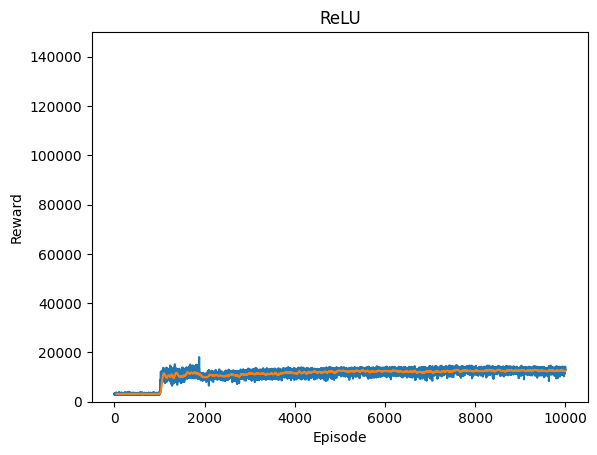

In [ ]:
plt.plot(tmp_df['episode'], tmp_df['reward'])
plt.plot(tmp_df['episode'], tmp_df['reward'].rolling(window=50).mean())
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title('ReLU')
plt.ylim(0, 150000)

plt.show()

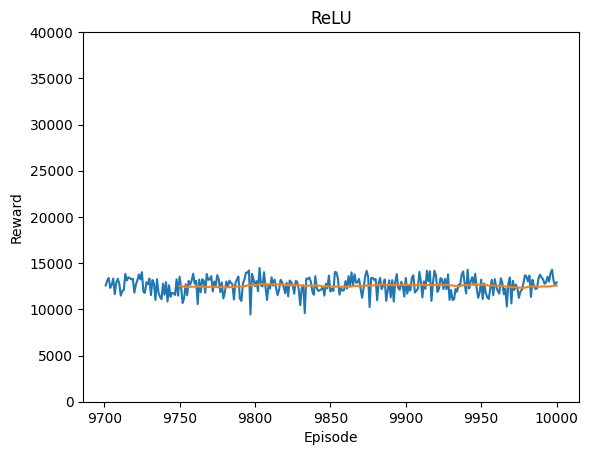

In [ ]:
plt.plot(tmp_df['episode'][-300:], tmp_df['reward'][-300:])
plt.plot(tmp_df['episode'][-300:], tmp_df['reward'][-300:].rolling(window=50).mean())
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title('ReLU')
plt.ylim(0, 40000)

plt.show()

## Intermediate Rewards

In [ ]:
def train_model_intermediate_rewards(agent, tracker, best_score, save_path="sac_humanoid.pth"):
  print(f"Starting training on {device}")

  for i_episode in tqdm(range(1, config['num_episodes'] + 1)):

      # Run Training Episode
      state, _ = env.reset(seed=SEED + i_episode)
      score = 0
      step_count = 0
      done = False

      while not done:
          step_count += 1

          if agent.total_steps < config['warmup_steps']:
              action = env.action_space.sample()
          else:
              action = agent.select_action(state)

          next_state, reward, term, trunc, _ = env.step(action)

          # calculate score before adding intermediate rewards
          score += reward

          #intermediate rewards
          reward = reward*reward # Rewards are squared which greatly increases the rewards for the torso moving upwards

          done = term or trunc
          mask = 1 if trunc else float(not done)

          agent.buffer.store(state, action, next_state, reward, mask)
          agent.total_steps += 1

          if agent.total_steps >= config['warmup_steps']:
              losses = agent.update()
              if losses:
                  tracker.record_training(losses)

          state = next_state


          if step_count >= config['max_steps']:
              done = True

      # Record episode stats
      tracker.record_episode(score, step_count)

      # Evaluation Logic
      if i_episode % config['eval_frequency'] == 0:
          # unpack the tuple: (Mean, Std)
          avg_eval, std_eval = evaluate_agent(agent, 'HumanoidStandup-v5', num_episodes=config['eval_episodes'])

          tracker.record_evaluation(i_episode, avg_eval)

          if avg_eval > best_score:
              best_score = avg_eval
              agent.save("best_sac_humanoid.pth")

      # Logging
      if i_episode % 100 == 0:
          recent = tracker.get_recent_stats()
          print(f"Ep {i_episode} | Recent Avg: {recent['mean_reward']:.1f} | Best Eval: {best_score:.1f}")

  print("Training Complete.")
  agent.save(save_path)


In [ ]:
config['num_episodes'] = 3000
config['max_steps'] = 100
config['hidden_sizes'] = [512,512]
config['gamma'] = 0.995
config['nonlinearity'] = F.relu
config['warmup_steps'] = 100000

tmp_agent = SACAgent(state_dim, action_dim, action_bound, config)
tmp_tracker = MetricsTracker()
best_score = -float('inf')

train_model_intermediate_rewards(tmp_agent, tmp_tracker, best_score, f'/content/drive/MyDrive/CMPE260Data/test5_model.pth')
tmp_df = tmp_tracker.to_dataframe()
tmp_df.to_csv(f'/content/drive/MyDrive/CMPE260Data/test5_model_data.csv')


Starting training on cuda


  3%|▎         | 102/3000 [00:22<41:34,  1.16it/s]

Ep 100 | Recent Avg: 3178.5 | Best Eval: 38780.4


  7%|▋         | 200/3000 [00:43<52:34,  1.13s/it]

Ep 200 | Recent Avg: 3225.7 | Best Eval: 38780.4


 10%|█         | 302/3000 [01:06<41:45,  1.08it/s]  

Ep 300 | Recent Avg: 3195.3 | Best Eval: 38780.4


 13%|█▎        | 402/3000 [01:30<59:27,  1.37s/it]  

Ep 400 | Recent Avg: 3173.8 | Best Eval: 38780.4


 17%|█▋        | 500/3000 [01:52<48:26,  1.16s/it]

Ep 500 | Recent Avg: 3189.6 | Best Eval: 38780.4


 20%|██        | 602/3000 [02:13<30:46,  1.30it/s]

Ep 600 | Recent Avg: 3141.1 | Best Eval: 38780.4


 23%|██▎       | 702/3000 [02:36<33:24,  1.15it/s]

Ep 700 | Recent Avg: 3192.3 | Best Eval: 38780.4


 27%|██▋       | 801/3000 [02:57<34:29,  1.06it/s]

Ep 800 | Recent Avg: 3190.5 | Best Eval: 38780.4


 30%|███       | 902/3000 [03:19<36:01,  1.03s/it]

Ep 900 | Recent Avg: 3180.4 | Best Eval: 38780.4


 33%|███▎      | 1000/3000 [03:40<36:52,  1.11s/it]

Ep 1000 | Recent Avg: 3157.9 | Best Eval: 40552.6


 37%|███▋      | 1100/3000 [05:57<1:35:55,  3.03s/it]

Ep 1100 | Recent Avg: 10092.4 | Best Eval: 115871.1


 40%|████      | 1200/3000 [08:17<1:47:38,  3.59s/it]

Ep 1200 | Recent Avg: 10430.6 | Best Eval: 115871.1


 43%|████▎     | 1300/3000 [10:35<1:38:34,  3.48s/it]

Ep 1300 | Recent Avg: 9935.3 | Best Eval: 115871.1


 47%|████▋     | 1400/3000 [12:58<1:30:25,  3.39s/it]

Ep 1400 | Recent Avg: 9571.7 | Best Eval: 115871.1


 50%|█████     | 1500/3000 [15:18<1:21:52,  3.28s/it]

Ep 1500 | Recent Avg: 9576.7 | Best Eval: 115871.1


 53%|█████▎    | 1600/3000 [17:38<1:27:56,  3.77s/it]

Ep 1600 | Recent Avg: 11074.6 | Best Eval: 115871.1


 57%|█████▋    | 1700/3000 [19:58<1:26:29,  3.99s/it]

Ep 1700 | Recent Avg: 11357.1 | Best Eval: 115871.1


 60%|██████    | 1800/3000 [22:21<1:25:12,  4.26s/it]

Ep 1800 | Recent Avg: 10053.2 | Best Eval: 115871.1


 63%|██████▎   | 1900/3000 [24:42<1:08:34,  3.74s/it]

Ep 1900 | Recent Avg: 9665.6 | Best Eval: 115871.1


 67%|██████▋   | 2000/3000 [27:00<53:57,  3.24s/it]

Ep 2000 | Recent Avg: 9936.9 | Best Eval: 115871.1


 70%|███████   | 2100/3000 [29:20<53:15,  3.55s/it]

Ep 2100 | Recent Avg: 9999.0 | Best Eval: 115871.1


 73%|███████▎  | 2200/3000 [31:39<48:11,  3.61s/it]

Ep 2200 | Recent Avg: 11649.6 | Best Eval: 115871.1


 77%|███████▋  | 2300/3000 [33:57<42:06,  3.61s/it]

Ep 2300 | Recent Avg: 11446.2 | Best Eval: 139125.9


 80%|████████  | 2400/3000 [36:18<36:47,  3.68s/it]

Ep 2400 | Recent Avg: 11559.0 | Best Eval: 139125.9


 83%|████████▎ | 2500/3000 [38:38<28:57,  3.48s/it]

Ep 2500 | Recent Avg: 10650.8 | Best Eval: 139125.9


 87%|████████▋ | 2600/3000 [40:59<23:59,  3.60s/it]

Ep 2600 | Recent Avg: 10144.7 | Best Eval: 139125.9


 90%|█████████ | 2700/3000 [43:20<18:55,  3.78s/it]

Ep 2700 | Recent Avg: 10959.7 | Best Eval: 139125.9


 93%|█████████▎| 2800/3000 [45:40<12:58,  3.89s/it]

Ep 2800 | Recent Avg: 11889.7 | Best Eval: 139125.9


 97%|█████████▋| 2900/3000 [48:01<05:57,  3.58s/it]

Ep 2900 | Recent Avg: 12215.8 | Best Eval: 139125.9


100%|██████████| 3000/3000 [50:22<00:00,  1.01s/it]

Ep 3000 | Recent Avg: 11411.0 | Best Eval: 139125.9
Training Complete.


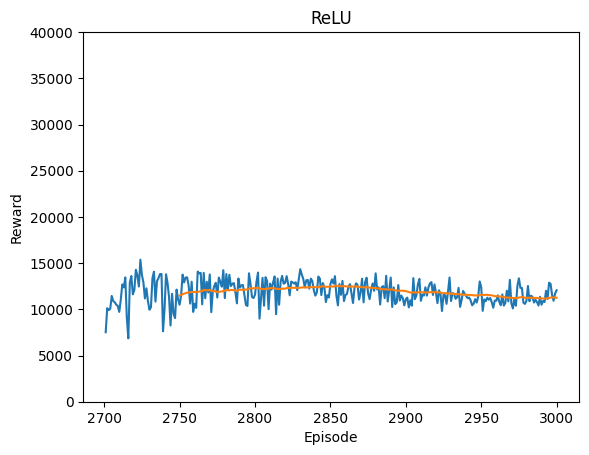

In [ ]:
plt.plot(tmp_df['episode'][-300:], tmp_df['reward'][-300:])
plt.plot(tmp_df['episode'][-300:], tmp_df['reward'][-300:].rolling(window=50).mean())
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title('ReLU')
plt.ylim(0, 40000)

plt.show()

In [ ]:
tmp_state, tmp_info = env.reset(seed=SEED)

In [ ]:
print(tmp_info)

{'x_position': np.float64(0.005479120971119267), 'y_position': np.float64(-0.0012224312049589538), 'z_distance_from_origin': np.float64(0.007171958398227651), 'tendon_length': array([-0.00981535,  0.00357793]), 'tendon_velocity': array([-0.00465324, -0.001191  ])}


In [ ]:
print(env.unwrapped.data.qpos)

[ 5.47912097e-03 -1.22243120e-03  1.12171958e-01  1.00394736e+00
 -8.11645304e-03  9.51244703e-03  5.22279404e-03  5.72128611e-03
 -7.43772735e-03 -9.92281242e-04 -2.58403952e-03  8.53529978e-03
  2.87730240e-03  6.45523227e-03 -1.13171602e-03 -5.45522556e-03
  1.09169574e-03 -8.72365488e-03  6.55262344e-03  2.63328798e-03
  5.16175480e-03 -2.90948064e-03  9.41396049e-03  7.86242243e-03]


In [ ]:
config['num_episodes'] = 4000
config['max_steps'] = 100
config['hidden_sizes'] = [512,512]
config['gamma'] = 0.995
config['nonlinearity'] = F.relu
config['warmup_steps'] = 100000

for i in range(8):
  tmp_agent = SACAgent(state_dim, action_dim, action_bound, config)
  tmp_tracker = MetricsTracker()
  best_score = -float('inf')

  train_model_intermediate_rewards(tmp_agent, tmp_tracker, best_score, f'/content/drive/MyDrive/CMPE260Data/test{i+6}_model.pth')
  tmp_df = tmp_tracker.to_dataframe()
  tmp_df.to_csv(f'/content/drive/MyDrive/CMPE260Data/test{i+6}_model_data.csv')




Starting training on cuda


  3%|▎         | 102/4000 [00:26<1:30:38,  1.40s/it]

Ep 100 | Recent Avg: 3155.6 | Best Eval: 48772.0


  5%|▌         | 202/4000 [00:51<1:02:48,  1.01it/s]

Ep 200 | Recent Avg: 3195.3 | Best Eval: 48772.0


  8%|▊         | 302/4000 [01:15<1:00:29,  1.02it/s]

Ep 300 | Recent Avg: 3191.5 | Best Eval: 48772.0


 10%|█         | 402/4000 [01:40<59:58,  1.00s/it]  

Ep 400 | Recent Avg: 3201.1 | Best Eval: 48772.0


 12%|█▎        | 500/4000 [02:05<1:21:02,  1.39s/it]

Ep 500 | Recent Avg: 3181.9 | Best Eval: 48772.0


 15%|█▌        | 601/4000 [02:29<1:00:05,  1.06s/it]

Ep 600 | Recent Avg: 3201.4 | Best Eval: 48772.0


 18%|█▊        | 702/4000 [02:54<50:52,  1.08it/s]  

Ep 700 | Recent Avg: 3194.5 | Best Eval: 48772.0


 20%|██        | 802/4000 [03:19<1:13:56,  1.39s/it]

Ep 800 | Recent Avg: 3159.0 | Best Eval: 48772.0


 23%|██▎       | 902/4000 [03:44<50:43,  1.02it/s]  

Ep 900 | Recent Avg: 3142.8 | Best Eval: 48772.0


 25%|██▌       | 1000/4000 [04:08<1:02:37,  1.25s/it]

Ep 1000 | Recent Avg: 3128.1 | Best Eval: 48772.0


 28%|██▊       | 1100/4000 [06:26<2:40:11,  3.31s/it]

Ep 1100 | Recent Avg: 9558.8 | Best Eval: 63792.9


 30%|███       | 1200/4000 [08:47<2:40:45,  3.44s/it]

Ep 1200 | Recent Avg: 11794.1 | Best Eval: 129066.2


 32%|███▎      | 1300/4000 [11:10<2:39:07,  3.54s/it]

Ep 1300 | Recent Avg: 12657.9 | Best Eval: 129657.1


 35%|███▌      | 1400/4000 [13:33<2:32:19,  3.52s/it]

Ep 1400 | Recent Avg: 11854.3 | Best Eval: 129657.1


 38%|███▊      | 1500/4000 [15:53<2:25:55,  3.50s/it]

Ep 1500 | Recent Avg: 10407.8 | Best Eval: 129657.1


 40%|████      | 1600/4000 [18:10<2:15:28,  3.39s/it]

Ep 1600 | Recent Avg: 9483.1 | Best Eval: 129657.1


 42%|████▎     | 1700/4000 [20:28<2:01:23,  3.17s/it]

Ep 1700 | Recent Avg: 10041.3 | Best Eval: 129657.1


 45%|████▌     | 1800/4000 [22:47<2:05:39,  3.43s/it]

Ep 1800 | Recent Avg: 9888.7 | Best Eval: 129657.1


 48%|████▊     | 1900/4000 [25:05<1:58:35,  3.39s/it]

Ep 1900 | Recent Avg: 9926.9 | Best Eval: 129657.1


 50%|█████     | 2000/4000 [27:24<1:52:11,  3.37s/it]

Ep 2000 | Recent Avg: 10595.6 | Best Eval: 129657.1


 52%|█████▎    | 2100/4000 [29:44<1:51:43,  3.53s/it]

Ep 2100 | Recent Avg: 10993.6 | Best Eval: 129657.1


 55%|█████▌    | 2200/4000 [32:03<1:47:22,  3.58s/it]

Ep 2200 | Recent Avg: 11490.8 | Best Eval: 129657.1


 57%|█████▊    | 2300/4000 [34:21<1:33:14,  3.29s/it]

Ep 2300 | Recent Avg: 11745.4 | Best Eval: 129657.1


 60%|██████    | 2400/4000 [36:41<1:32:27,  3.47s/it]

Ep 2400 | Recent Avg: 12860.4 | Best Eval: 129657.1


 62%|██████▎   | 2500/4000 [39:02<1:34:21,  3.77s/it]

Ep 2500 | Recent Avg: 11205.7 | Best Eval: 129657.1


 65%|██████▌   | 2600/4000 [41:23<1:30:32,  3.88s/it]

Ep 2600 | Recent Avg: 11178.6 | Best Eval: 129657.1


 68%|██████▊   | 2700/4000 [43:44<1:21:23,  3.76s/it]

Ep 2700 | Recent Avg: 11289.3 | Best Eval: 129657.1


 70%|███████   | 2800/4000 [46:04<1:18:39,  3.93s/it]

Ep 2800 | Recent Avg: 12001.0 | Best Eval: 129657.1


 72%|███████▎  | 2900/4000 [48:25<1:10:19,  3.84s/it]

Ep 2900 | Recent Avg: 12390.8 | Best Eval: 129657.1


 75%|███████▌  | 3000/4000 [50:48<1:09:23,  4.16s/it]

Ep 3000 | Recent Avg: 12766.5 | Best Eval: 129657.1


 78%|███████▊  | 3100/4000 [53:11<1:01:22,  4.09s/it]

Ep 3100 | Recent Avg: 12908.0 | Best Eval: 129657.1


 80%|████████  | 3200/4000 [55:29<43:55,  3.29s/it]

Ep 3200 | Recent Avg: 12880.2 | Best Eval: 129657.1


 82%|████████▎ | 3300/4000 [57:50<45:53,  3.93s/it]

Ep 3300 | Recent Avg: 12662.9 | Best Eval: 129657.1


 85%|████████▌ | 3400/4000 [1:00:09<39:04,  3.91s/it]

Ep 3400 | Recent Avg: 12895.9 | Best Eval: 129657.1


 88%|████████▊ | 3500/4000 [1:02:29<31:55,  3.83s/it]

Ep 3500 | Recent Avg: 9431.7 | Best Eval: 129657.1


 90%|█████████ | 3600/4000 [1:04:47<23:43,  3.56s/it]

Ep 3600 | Recent Avg: 5974.2 | Best Eval: 129657.1


 92%|█████████▎| 3700/4000 [1:07:07<18:49,  3.77s/it]

Ep 3700 | Recent Avg: 6004.4 | Best Eval: 129657.1


 95%|█████████▌| 3800/4000 [1:09:25<11:45,  3.53s/it]

Ep 3800 | Recent Avg: 6119.7 | Best Eval: 129657.1


 98%|█████████▊| 3900/4000 [1:11:45<06:06,  3.66s/it]

Ep 3900 | Recent Avg: 6187.8 | Best Eval: 129657.1


100%|██████████| 4000/4000 [1:14:04<00:00,  1.11s/it]

Ep 4000 | Recent Avg: 6856.1 | Best Eval: 129657.1
Training Complete.


Starting training on cuda


  3%|▎         | 102/4000 [00:24<1:02:45,  1.04it/s]

Ep 100 | Recent Avg: 3152.9 | Best Eval: 50405.2


  5%|▌         | 202/4000 [00:49<1:08:27,  1.08s/it]

Ep 200 | Recent Avg: 3185.0 | Best Eval: 50405.2


  8%|▊         | 301/4000 [01:13<1:05:16,  1.06s/it]

Ep 300 | Recent Avg: 3189.4 | Best Eval: 50405.2


 10%|█         | 402/4000 [01:37<52:12,  1.15it/s]  

Ep 400 | Recent Avg: 3186.9 | Best Eval: 50405.2


 13%|█▎        | 502/4000 [02:02<1:19:10,  1.36s/it]

Ep 500 | Recent Avg: 3173.3 | Best Eval: 50405.2


 15%|█▌        | 602/4000 [02:26<54:36,  1.04it/s]  

Ep 600 | Recent Avg: 3166.4 | Best Eval: 50405.2


 18%|█▊        | 702/4000 [02:51<53:05,  1.04it/s]  

Ep 700 | Recent Avg: 3181.5 | Best Eval: 50405.2


 20%|██        | 800/4000 [03:14<1:10:42,  1.33s/it]

Ep 800 | Recent Avg: 3210.3 | Best Eval: 50405.2


 23%|██▎       | 902/4000 [03:39<44:30,  1.16it/s]  

Ep 900 | Recent Avg: 3169.9 | Best Eval: 50405.2


 25%|██▌       | 1000/4000 [04:02<1:33:00,  1.86s/it]

Ep 1000 | Recent Avg: 3188.3 | Best Eval: 50405.2


 28%|██▊       | 1100/4000 [06:21<2:39:48,  3.31s/it]

Ep 1100 | Recent Avg: 10234.4 | Best Eval: 113690.5


 30%|███       | 1200/4000 [08:40<2:23:45,  3.08s/it]

Ep 1200 | Recent Avg: 9073.0 | Best Eval: 113690.5


 32%|███▎      | 1300/4000 [11:00<2:26:49,  3.26s/it]

Ep 1300 | Recent Avg: 8791.6 | Best Eval: 113690.5


 35%|███▌      | 1400/4000 [13:20<2:31:53,  3.51s/it]

Ep 1400 | Recent Avg: 8468.6 | Best Eval: 113690.5


 38%|███▊      | 1500/4000 [15:41<2:31:02,  3.62s/it]

Ep 1500 | Recent Avg: 9412.1 | Best Eval: 113690.5


 40%|████      | 1600/4000 [18:01<2:31:44,  3.79s/it]

Ep 1600 | Recent Avg: 9406.2 | Best Eval: 113690.5


 42%|████▎     | 1700/4000 [20:19<2:14:43,  3.51s/it]

Ep 1700 | Recent Avg: 9271.9 | Best Eval: 113690.5


 45%|████▌     | 1800/4000 [22:41<2:32:59,  4.17s/it]

Ep 1800 | Recent Avg: 10290.5 | Best Eval: 113690.5


 48%|████▊     | 1900/4000 [25:03<2:08:58,  3.69s/it]

Ep 1900 | Recent Avg: 10503.8 | Best Eval: 113690.5


 50%|█████     | 2000/4000 [27:25<2:12:52,  3.99s/it]

Ep 2000 | Recent Avg: 11344.9 | Best Eval: 113690.5


 52%|█████▎    | 2100/4000 [29:45<2:02:40,  3.87s/it]

Ep 2100 | Recent Avg: 11872.5 | Best Eval: 113690.5


 55%|█████▌    | 2200/4000 [32:06<2:01:20,  4.04s/it]

Ep 2200 | Recent Avg: 11890.9 | Best Eval: 113690.5


 57%|█████▊    | 2300/4000 [34:27<1:45:30,  3.72s/it]

Ep 2300 | Recent Avg: 9264.1 | Best Eval: 113690.5


 60%|██████    | 2400/4000 [36:48<1:49:36,  4.11s/it]

Ep 2400 | Recent Avg: 9965.6 | Best Eval: 113690.5


 62%|██████▎   | 2500/4000 [39:09<1:36:55,  3.88s/it]

Ep 2500 | Recent Avg: 11965.6 | Best Eval: 113690.5


 65%|██████▌   | 2600/4000 [41:29<1:28:44,  3.80s/it]

Ep 2600 | Recent Avg: 11770.7 | Best Eval: 113690.5


 68%|██████▊   | 2700/4000 [43:47<1:14:31,  3.44s/it]

Ep 2700 | Recent Avg: 11928.3 | Best Eval: 113690.5


 70%|███████   | 2800/4000 [46:08<1:17:46,  3.89s/it]

Ep 2800 | Recent Avg: 12105.8 | Best Eval: 113690.5


 72%|███████▎  | 2900/4000 [48:26<1:09:22,  3.78s/it]

Ep 2900 | Recent Avg: 11300.4 | Best Eval: 113690.5


 75%|███████▌  | 3000/4000 [50:45<52:15,  3.14s/it]

Ep 3000 | Recent Avg: 9447.5 | Best Eval: 113690.5


 78%|███████▊  | 3100/4000 [53:02<55:35,  3.71s/it]

Ep 3100 | Recent Avg: 8837.4 | Best Eval: 113690.5


 80%|████████  | 3200/4000 [55:20<47:32,  3.57s/it]

Ep 3200 | Recent Avg: 8488.5 | Best Eval: 113690.5


 82%|████████▎ | 3300/4000 [57:36<40:26,  3.47s/it]

Ep 3300 | Recent Avg: 8349.2 | Best Eval: 113690.5


 85%|████████▌ | 3400/4000 [59:51<31:40,  3.17s/it]

Ep 3400 | Recent Avg: 8730.1 | Best Eval: 113690.5


 88%|████████▊ | 3500/4000 [1:02:08<28:04,  3.37s/it]

Ep 3500 | Recent Avg: 10154.1 | Best Eval: 113690.5


 90%|█████████ | 3600/4000 [1:04:25<22:27,  3.37s/it]

Ep 3600 | Recent Avg: 9849.6 | Best Eval: 113690.5


 92%|█████████▎| 3700/4000 [1:06:42<18:09,  3.63s/it]

Ep 3700 | Recent Avg: 9445.8 | Best Eval: 113690.5


 95%|█████████▌| 3800/4000 [1:09:00<11:18,  3.39s/it]

Ep 3800 | Recent Avg: 11555.2 | Best Eval: 113690.5


 98%|█████████▊| 3900/4000 [1:11:18<06:17,  3.77s/it]

Ep 3900 | Recent Avg: 12342.9 | Best Eval: 113690.5


100%|██████████| 4000/4000 [1:13:37<00:00,  1.10s/it]

Ep 4000 | Recent Avg: 13058.5 | Best Eval: 113690.5
Training Complete.


Starting training on cuda


  3%|▎         | 101/4000 [00:22<1:07:35,  1.04s/it]

Ep 100 | Recent Avg: 3207.6 | Best Eval: 80193.1


  5%|▌         | 202/4000 [00:44<48:44,  1.30it/s]  

Ep 200 | Recent Avg: 3139.7 | Best Eval: 80193.1


  8%|▊         | 302/4000 [01:07<54:01,  1.14it/s]  

Ep 300 | Recent Avg: 3214.2 | Best Eval: 80193.1


 10%|█         | 402/4000 [01:30<52:12,  1.15it/s]  

Ep 400 | Recent Avg: 3180.6 | Best Eval: 80193.1


 13%|█▎        | 502/4000 [01:52<45:00,  1.30it/s]  

Ep 500 | Recent Avg: 3191.6 | Best Eval: 80193.1


 15%|█▌        | 602/4000 [02:16<56:21,  1.00it/s]  

Ep 600 | Recent Avg: 3178.5 | Best Eval: 80193.1


 18%|█▊        | 702/4000 [02:38<47:36,  1.15it/s]  

Ep 700 | Recent Avg: 3165.8 | Best Eval: 80193.1


 20%|██        | 801/4000 [02:59<56:10,  1.05s/it]

Ep 800 | Recent Avg: 3168.1 | Best Eval: 80193.1


 23%|██▎       | 902/4000 [03:22<1:00:31,  1.17s/it]

Ep 900 | Recent Avg: 3177.5 | Best Eval: 80193.1


 25%|██▌       | 1000/4000 [03:43<51:48,  1.04s/it]

Ep 1000 | Recent Avg: 3165.1 | Best Eval: 80193.1


 28%|██▊       | 1100/4000 [06:00<2:32:54,  3.16s/it]

Ep 1100 | Recent Avg: 10637.7 | Best Eval: 105140.4


 30%|███       | 1200/4000 [08:18<2:36:18,  3.35s/it]

Ep 1200 | Recent Avg: 9932.2 | Best Eval: 105140.4


 32%|███▎      | 1300/4000 [10:35<2:20:51,  3.13s/it]

Ep 1300 | Recent Avg: 10331.7 | Best Eval: 105140.4


 35%|███▌      | 1400/4000 [12:55<2:24:54,  3.34s/it]

Ep 1400 | Recent Avg: 10711.9 | Best Eval: 105140.4


 38%|███▊      | 1500/4000 [15:13<2:28:06,  3.55s/it]

Ep 1500 | Recent Avg: 10620.9 | Best Eval: 128158.9


 40%|████      | 1600/4000 [17:30<2:17:47,  3.44s/it]

Ep 1600 | Recent Avg: 11376.6 | Best Eval: 134716.9


 42%|████▎     | 1700/4000 [19:50<2:37:11,  4.10s/it]

Ep 1700 | Recent Avg: 11197.6 | Best Eval: 134716.9


 45%|████▌     | 1800/4000 [22:10<2:25:13,  3.96s/it]

Ep 1800 | Recent Avg: 10670.5 | Best Eval: 134716.9


 48%|████▊     | 1900/4000 [24:28<1:58:03,  3.37s/it]

Ep 1900 | Recent Avg: 10902.9 | Best Eval: 134716.9


 50%|█████     | 2000/4000 [26:46<1:57:00,  3.51s/it]

Ep 2000 | Recent Avg: 11403.4 | Best Eval: 134716.9


 52%|█████▎    | 2100/4000 [29:04<1:55:00,  3.63s/it]

Ep 2100 | Recent Avg: 12150.6 | Best Eval: 134716.9


 55%|█████▌    | 2200/4000 [31:22<1:50:18,  3.68s/it]

Ep 2200 | Recent Avg: 12426.1 | Best Eval: 134716.9


 57%|█████▊    | 2300/4000 [33:41<1:44:16,  3.68s/it]

Ep 2300 | Recent Avg: 11205.6 | Best Eval: 134716.9


 60%|██████    | 2400/4000 [35:59<1:39:13,  3.72s/it]

Ep 2400 | Recent Avg: 12493.2 | Best Eval: 134716.9


 62%|██████▎   | 2500/4000 [38:18<1:31:23,  3.66s/it]

Ep 2500 | Recent Avg: 12444.7 | Best Eval: 134716.9


 65%|██████▌   | 2600/4000 [40:35<1:23:21,  3.57s/it]

Ep 2600 | Recent Avg: 11107.7 | Best Eval: 134716.9


 68%|██████▊   | 2700/4000 [42:51<1:16:01,  3.51s/it]

Ep 2700 | Recent Avg: 8868.6 | Best Eval: 134716.9


 70%|███████   | 2800/4000 [45:07<1:11:00,  3.55s/it]

Ep 2800 | Recent Avg: 11815.8 | Best Eval: 134716.9


 72%|███████▎  | 2900/4000 [47:25<1:04:49,  3.54s/it]

Ep 2900 | Recent Avg: 12053.8 | Best Eval: 134716.9


 75%|███████▌  | 3000/4000 [49:40<54:40,  3.28s/it]

Ep 3000 | Recent Avg: 9895.2 | Best Eval: 134716.9


 78%|███████▊  | 3100/4000 [51:57<51:32,  3.44s/it]

Ep 3100 | Recent Avg: 8931.7 | Best Eval: 134716.9


 80%|████████  | 3200/4000 [54:13<44:43,  3.35s/it]

Ep 3200 | Recent Avg: 8307.6 | Best Eval: 134716.9


 82%|████████▎ | 3300/4000 [56:30<41:02,  3.52s/it]

Ep 3300 | Recent Avg: 8453.3 | Best Eval: 134716.9


 85%|████████▌ | 3400/4000 [58:46<33:44,  3.37s/it]

Ep 3400 | Recent Avg: 8634.9 | Best Eval: 134716.9


 88%|████████▊ | 3500/4000 [1:01:03<29:37,  3.55s/it]

Ep 3500 | Recent Avg: 8521.1 | Best Eval: 134716.9


 90%|█████████ | 3600/4000 [1:03:20<24:24,  3.66s/it]

Ep 3600 | Recent Avg: 8402.0 | Best Eval: 134716.9


 92%|█████████▎| 3700/4000 [1:05:38<18:02,  3.61s/it]

Ep 3700 | Recent Avg: 8158.2 | Best Eval: 134716.9


 95%|█████████▌| 3800/4000 [1:07:54<11:29,  3.45s/it]

Ep 3800 | Recent Avg: 8755.5 | Best Eval: 134716.9


 98%|█████████▊| 3900/4000 [1:10:11<06:21,  3.81s/it]

Ep 3900 | Recent Avg: 8760.3 | Best Eval: 134716.9


100%|██████████| 4000/4000 [1:12:27<00:00,  1.09s/it]

Ep 4000 | Recent Avg: 9210.1 | Best Eval: 134716.9
Training Complete.


Starting training on cuda


  3%|▎         | 101/4000 [00:24<1:22:32,  1.27s/it]

Ep 100 | Recent Avg: 3165.2 | Best Eval: 35465.4


  5%|▌         | 202/4000 [00:48<59:49,  1.06it/s]  

Ep 200 | Recent Avg: 3167.5 | Best Eval: 35465.4


  8%|▊         | 302/4000 [01:12<58:23,  1.06it/s]  

Ep 300 | Recent Avg: 3186.4 | Best Eval: 35465.4


 10%|█         | 400/4000 [01:35<1:15:01,  1.25s/it]

Ep 400 | Recent Avg: 3177.3 | Best Eval: 35465.4


 13%|█▎        | 503/4000 [01:58<48:27,  1.20it/s]  

Ep 500 | Recent Avg: 3196.3 | Best Eval: 35465.4


 15%|█▌        | 602/4000 [02:23<1:17:36,  1.37s/it]

Ep 600 | Recent Avg: 3177.4 | Best Eval: 35465.4


 18%|█▊        | 702/4000 [02:47<52:13,  1.05it/s]  

Ep 700 | Recent Avg: 3143.5 | Best Eval: 35465.4


 20%|██        | 802/4000 [03:11<49:49,  1.07it/s]  

Ep 800 | Recent Avg: 3193.2 | Best Eval: 35465.4


 22%|██▎       | 900/4000 [03:33<1:02:10,  1.20s/it]

Ep 900 | Recent Avg: 3197.1 | Best Eval: 35465.4


 25%|██▌       | 1000/4000 [03:56<46:31,  1.07it/s]

Ep 1000 | Recent Avg: 3200.7 | Best Eval: 35465.4


 28%|██▊       | 1100/4000 [06:13<2:52:17,  3.56s/it]

Ep 1100 | Recent Avg: 9556.3 | Best Eval: 69477.6


 30%|███       | 1200/4000 [08:32<2:50:22,  3.65s/it]

Ep 1200 | Recent Avg: 9923.0 | Best Eval: 107374.2


 32%|███▎      | 1300/4000 [10:50<2:38:05,  3.51s/it]

Ep 1300 | Recent Avg: 12101.1 | Best Eval: 107374.2


 35%|███▌      | 1400/4000 [13:07<2:19:09,  3.21s/it]

Ep 1400 | Recent Avg: 10294.3 | Best Eval: 107374.2


 38%|███▊      | 1500/4000 [15:27<2:29:36,  3.59s/it]

Ep 1500 | Recent Avg: 12099.4 | Best Eval: 107374.2


 40%|████      | 1600/4000 [17:46<2:27:15,  3.68s/it]

Ep 1600 | Recent Avg: 12314.4 | Best Eval: 107374.2


 42%|████▎     | 1700/4000 [20:03<2:08:30,  3.35s/it]

Ep 1700 | Recent Avg: 12319.4 | Best Eval: 107374.2


 45%|████▌     | 1800/4000 [22:20<2:08:26,  3.50s/it]

Ep 1800 | Recent Avg: 10294.0 | Best Eval: 107374.2


 48%|████▊     | 1900/4000 [24:36<1:55:39,  3.30s/it]

Ep 1900 | Recent Avg: 11559.3 | Best Eval: 136530.5


 50%|█████     | 2000/4000 [26:55<1:57:07,  3.51s/it]

Ep 2000 | Recent Avg: 12692.4 | Best Eval: 136530.5


 52%|█████▎    | 2100/4000 [29:11<1:46:45,  3.37s/it]

Ep 2100 | Recent Avg: 11321.6 | Best Eval: 136530.5


 55%|█████▌    | 2200/4000 [31:29<1:57:51,  3.93s/it]

Ep 2200 | Recent Avg: 12040.6 | Best Eval: 136530.5


 57%|█████▊    | 2300/4000 [33:47<1:48:41,  3.84s/it]

Ep 2300 | Recent Avg: 12312.1 | Best Eval: 136530.5


 60%|██████    | 2400/4000 [36:05<1:40:46,  3.78s/it]

Ep 2400 | Recent Avg: 11412.7 | Best Eval: 136530.5


 62%|██████▎   | 2500/4000 [38:26<1:29:04,  3.56s/it]

Ep 2500 | Recent Avg: 12047.5 | Best Eval: 136530.5


 65%|██████▌   | 2600/4000 [40:46<1:32:52,  3.98s/it]

Ep 2600 | Recent Avg: 12493.7 | Best Eval: 136530.5


 68%|██████▊   | 2700/4000 [43:04<1:16:16,  3.52s/it]

Ep 2700 | Recent Avg: 11781.2 | Best Eval: 136530.5


 70%|███████   | 2800/4000 [45:20<1:06:48,  3.34s/it]

Ep 2800 | Recent Avg: 12012.9 | Best Eval: 136530.5


 72%|███████▎  | 2900/4000 [47:40<1:05:54,  3.60s/it]

Ep 2900 | Recent Avg: 10502.9 | Best Eval: 136530.5


 75%|███████▌  | 3000/4000 [49:59<1:02:21,  3.74s/it]

Ep 3000 | Recent Avg: 9822.3 | Best Eval: 136530.5


 78%|███████▊  | 3100/4000 [52:18<53:20,  3.56s/it]

Ep 3100 | Recent Avg: 8459.1 | Best Eval: 136530.5


 80%|████████  | 3200/4000 [54:36<51:22,  3.85s/it]

Ep 3200 | Recent Avg: 8495.9 | Best Eval: 136530.5


 82%|████████▎ | 3300/4000 [56:55<44:07,  3.78s/it]

Ep 3300 | Recent Avg: 8132.5 | Best Eval: 136530.5


 85%|████████▌ | 3400/4000 [59:11<34:47,  3.48s/it]

Ep 3400 | Recent Avg: 8524.2 | Best Eval: 136530.5


 88%|████████▊ | 3500/4000 [1:01:29<31:15,  3.75s/it]

Ep 3500 | Recent Avg: 8924.3 | Best Eval: 136530.5


 90%|█████████ | 3600/4000 [1:03:46<23:27,  3.52s/it]

Ep 3600 | Recent Avg: 8434.2 | Best Eval: 136530.5


 92%|█████████▎| 3700/4000 [1:06:04<20:30,  4.10s/it]

Ep 3700 | Recent Avg: 8510.2 | Best Eval: 136530.5


 95%|█████████▌| 3800/4000 [1:08:20<11:13,  3.37s/it]

Ep 3800 | Recent Avg: 9015.4 | Best Eval: 136530.5


 98%|█████████▊| 3900/4000 [1:10:36<06:07,  3.67s/it]

Ep 3900 | Recent Avg: 9516.1 | Best Eval: 136530.5


100%|██████████| 4000/4000 [1:12:53<00:00,  1.09s/it]

Ep 4000 | Recent Avg: 9555.9 | Best Eval: 136530.5
Training Complete.


Starting training on cuda


  3%|▎         | 102/4000 [00:21<50:08,  1.30it/s]  

Ep 100 | Recent Avg: 3229.2 | Best Eval: 50825.5


  5%|▌         | 202/4000 [00:44<54:01,  1.17it/s]  

Ep 200 | Recent Avg: 3169.3 | Best Eval: 50825.5


  8%|▊         | 301/4000 [01:04<55:16,  1.12it/s]  

Ep 300 | Recent Avg: 3193.0 | Best Eval: 50825.5


 10%|█         | 402/4000 [01:27<1:10:02,  1.17s/it]

Ep 400 | Recent Avg: 3198.9 | Best Eval: 50825.5


 13%|█▎        | 502/4000 [01:49<49:21,  1.18it/s]  

Ep 500 | Recent Avg: 3207.2 | Best Eval: 50825.5


 15%|█▌        | 603/4000 [02:10<42:11,  1.34it/s]

Ep 600 | Recent Avg: 3170.9 | Best Eval: 50825.5


 18%|█▊        | 702/4000 [02:32<51:16,  1.07it/s]  

Ep 700 | Recent Avg: 3214.9 | Best Eval: 50825.5


 20%|██        | 802/4000 [02:54<45:48,  1.16it/s]  

Ep 800 | Recent Avg: 3215.3 | Best Eval: 50825.5


 23%|██▎       | 901/4000 [03:16<53:24,  1.03s/it]

Ep 900 | Recent Avg: 3214.0 | Best Eval: 50825.5


 25%|██▌       | 1000/4000 [03:39<1:05:33,  1.31s/it]

Ep 1000 | Recent Avg: 3204.3 | Best Eval: 56718.7


 28%|██▊       | 1100/4000 [05:55<2:43:01,  3.37s/it]

Ep 1100 | Recent Avg: 9655.2 | Best Eval: 63303.7


 30%|███       | 1200/4000 [08:12<2:38:02,  3.39s/it]

Ep 1200 | Recent Avg: 9650.5 | Best Eval: 94370.2


 32%|███▎      | 1300/4000 [10:30<2:34:28,  3.43s/it]

Ep 1300 | Recent Avg: 9674.4 | Best Eval: 94370.2


 35%|███▌      | 1400/4000 [12:48<2:30:13,  3.47s/it]

Ep 1400 | Recent Avg: 9960.8 | Best Eval: 94370.2


 38%|███▊      | 1500/4000 [15:08<2:24:32,  3.47s/it]

Ep 1500 | Recent Avg: 10596.1 | Best Eval: 94370.2


 40%|████      | 1600/4000 [17:23<2:04:59,  3.12s/it]

Ep 1600 | Recent Avg: 10165.1 | Best Eval: 94370.2


 42%|████▎     | 1700/4000 [19:41<2:10:04,  3.39s/it]

Ep 1700 | Recent Avg: 10539.8 | Best Eval: 94370.2


 45%|████▌     | 1800/4000 [21:58<2:06:36,  3.45s/it]

Ep 1800 | Recent Avg: 9455.8 | Best Eval: 94370.2


 48%|████▊     | 1900/4000 [24:13<1:55:50,  3.31s/it]

Ep 1900 | Recent Avg: 9226.5 | Best Eval: 94370.2


 50%|█████     | 2000/4000 [26:30<1:55:22,  3.46s/it]

Ep 2000 | Recent Avg: 10291.8 | Best Eval: 94370.2


 52%|█████▎    | 2100/4000 [28:46<1:49:52,  3.47s/it]

Ep 2100 | Recent Avg: 9450.7 | Best Eval: 94370.2


 55%|█████▌    | 2200/4000 [31:04<1:48:32,  3.62s/it]

Ep 2200 | Recent Avg: 8860.1 | Best Eval: 94370.2


 57%|█████▊    | 2300/4000 [33:19<1:32:22,  3.26s/it]

Ep 2300 | Recent Avg: 8573.3 | Best Eval: 94370.2


 60%|██████    | 2400/4000 [35:37<1:34:26,  3.54s/it]

Ep 2400 | Recent Avg: 8486.6 | Best Eval: 94370.2


 62%|██████▎   | 2500/4000 [37:59<1:53:01,  4.52s/it]

Ep 2500 | Recent Avg: 8744.3 | Best Eval: 94370.2


 65%|██████▌   | 2600/4000 [40:16<1:18:23,  3.36s/it]

Ep 2600 | Recent Avg: 8785.0 | Best Eval: 94370.2


 68%|██████▊   | 2700/4000 [42:33<1:18:47,  3.64s/it]

Ep 2700 | Recent Avg: 9233.4 | Best Eval: 94370.2


 70%|███████   | 2800/4000 [44:52<1:22:31,  4.13s/it]

Ep 2800 | Recent Avg: 10269.2 | Best Eval: 94824.3


 72%|███████▎  | 2900/4000 [47:09<1:04:42,  3.53s/it]

Ep 2900 | Recent Avg: 11285.9 | Best Eval: 94824.3


 75%|███████▌  | 3000/4000 [49:27<59:43,  3.58s/it]

Ep 3000 | Recent Avg: 10934.3 | Best Eval: 94824.3


 78%|███████▊  | 3100/4000 [51:45<56:13,  3.75s/it]

Ep 3100 | Recent Avg: 10391.6 | Best Eval: 94824.3


 80%|████████  | 3200/4000 [54:01<44:00,  3.30s/it]

Ep 3200 | Recent Avg: 10377.2 | Best Eval: 94824.3


 82%|████████▎ | 3300/4000 [56:18<39:50,  3.42s/it]

Ep 3300 | Recent Avg: 10106.3 | Best Eval: 94824.3


 85%|████████▌ | 3400/4000 [58:34<33:56,  3.39s/it]

Ep 3400 | Recent Avg: 10093.8 | Best Eval: 94824.3


 88%|████████▊ | 3500/4000 [1:00:51<29:29,  3.54s/it]

Ep 3500 | Recent Avg: 9236.9 | Best Eval: 94824.3


 90%|█████████ | 3600/4000 [1:03:08<24:48,  3.72s/it]

Ep 3600 | Recent Avg: 7228.8 | Best Eval: 94824.3


 92%|█████████▎| 3700/4000 [1:05:25<18:48,  3.76s/it]

Ep 3700 | Recent Avg: 8334.1 | Best Eval: 94824.3


 95%|█████████▌| 3800/4000 [1:07:43<11:59,  3.60s/it]

Ep 3800 | Recent Avg: 8062.0 | Best Eval: 94824.3


 98%|█████████▊| 3900/4000 [1:09:58<05:40,  3.41s/it]

Ep 3900 | Recent Avg: 8720.0 | Best Eval: 94824.3


100%|██████████| 4000/4000 [1:12:17<00:00,  1.08s/it]

Ep 4000 | Recent Avg: 10140.8 | Best Eval: 94824.3
Training Complete.


Starting training on cuda


  3%|▎         | 101/4000 [00:22<1:04:22,  1.01it/s]

Ep 100 | Recent Avg: 3156.9 | Best Eval: 72221.4


  5%|▌         | 202/4000 [00:44<50:54,  1.24it/s]  

Ep 200 | Recent Avg: 3179.1 | Best Eval: 72221.4


  8%|▊         | 302/4000 [01:07<53:06,  1.16it/s]  

Ep 300 | Recent Avg: 3147.2 | Best Eval: 72221.4


 10%|█         | 400/4000 [01:29<1:11:08,  1.19s/it]

Ep 400 | Recent Avg: 3173.2 | Best Eval: 72221.4


 13%|█▎        | 501/4000 [01:51<1:03:18,  1.09s/it]

Ep 500 | Recent Avg: 3148.9 | Best Eval: 72221.4


 15%|█▌        | 602/4000 [02:13<49:34,  1.14it/s]  

Ep 600 | Recent Avg: 3177.1 | Best Eval: 72221.4


 18%|█▊        | 700/4000 [02:35<1:03:02,  1.15s/it]

Ep 700 | Recent Avg: 3185.0 | Best Eval: 72221.4


 20%|██        | 802/4000 [02:58<42:29,  1.25it/s]

Ep 800 | Recent Avg: 3171.3 | Best Eval: 72221.4


 23%|██▎       | 902/4000 [03:21<45:07,  1.14it/s]  

Ep 900 | Recent Avg: 3130.7 | Best Eval: 72221.4


 25%|██▌       | 1000/4000 [03:43<1:02:00,  1.24s/it]

Ep 1000 | Recent Avg: 3185.3 | Best Eval: 72221.4


 28%|██▊       | 1100/4000 [06:01<2:33:01,  3.17s/it]

Ep 1100 | Recent Avg: 10865.3 | Best Eval: 87130.8


 30%|███       | 1200/4000 [08:21<2:47:48,  3.60s/it]

Ep 1200 | Recent Avg: 10193.6 | Best Eval: 87130.8


 32%|███▎      | 1300/4000 [10:41<2:33:56,  3.42s/it]

Ep 1300 | Recent Avg: 10082.9 | Best Eval: 96594.2


 35%|███▌      | 1400/4000 [12:59<2:27:49,  3.41s/it]

Ep 1400 | Recent Avg: 8816.3 | Best Eval: 96594.2


 38%|███▊      | 1500/4000 [15:20<2:20:43,  3.38s/it]

Ep 1500 | Recent Avg: 9111.7 | Best Eval: 96594.2


 40%|████      | 1600/4000 [17:39<2:24:23,  3.61s/it]

Ep 1600 | Recent Avg: 8072.5 | Best Eval: 96594.2


 42%|████▎     | 1700/4000 [19:57<2:13:25,  3.48s/it]

Ep 1700 | Recent Avg: 9340.8 | Best Eval: 96594.2


 45%|████▌     | 1800/4000 [22:15<2:10:46,  3.57s/it]

Ep 1800 | Recent Avg: 10587.6 | Best Eval: 96594.2


 48%|████▊     | 1900/4000 [24:34<2:12:37,  3.79s/it]

Ep 1900 | Recent Avg: 9703.7 | Best Eval: 96594.2


 50%|█████     | 2000/4000 [26:51<1:50:21,  3.31s/it]

Ep 2000 | Recent Avg: 10129.8 | Best Eval: 104839.3


 52%|█████▎    | 2100/4000 [29:08<1:51:06,  3.51s/it]

Ep 2100 | Recent Avg: 10163.3 | Best Eval: 104839.3


 55%|█████▌    | 2200/4000 [31:29<1:53:03,  3.77s/it]

Ep 2200 | Recent Avg: 8922.6 | Best Eval: 104839.3


 57%|█████▊    | 2300/4000 [33:46<1:29:07,  3.15s/it]

Ep 2300 | Recent Avg: 8636.0 | Best Eval: 104839.3


 60%|██████    | 2400/4000 [36:06<1:35:46,  3.59s/it]

Ep 2400 | Recent Avg: 9029.7 | Best Eval: 104839.3


 62%|██████▎   | 2500/4000 [38:25<1:35:43,  3.83s/it]

Ep 2500 | Recent Avg: 9087.9 | Best Eval: 104839.3


 65%|██████▌   | 2600/4000 [40:46<1:26:16,  3.70s/it]

Ep 2600 | Recent Avg: 10296.7 | Best Eval: 106479.3


 68%|██████▊   | 2700/4000 [43:06<1:18:06,  3.61s/it]

Ep 2700 | Recent Avg: 10598.5 | Best Eval: 108263.7


 70%|███████   | 2800/4000 [45:29<1:16:42,  3.84s/it]

Ep 2800 | Recent Avg: 10812.1 | Best Eval: 108263.7


 72%|███████▎  | 2900/4000 [47:49<1:12:26,  3.95s/it]

Ep 2900 | Recent Avg: 11154.7 | Best Eval: 108263.7


 75%|███████▌  | 3000/4000 [50:08<1:01:14,  3.67s/it]

Ep 3000 | Recent Avg: 10398.2 | Best Eval: 108263.7


 78%|███████▊  | 3100/4000 [52:25<55:22,  3.69s/it]

Ep 3100 | Recent Avg: 11019.5 | Best Eval: 108263.7


 80%|████████  | 3200/4000 [54:43<47:07,  3.53s/it]

Ep 3200 | Recent Avg: 10605.7 | Best Eval: 108263.7


 82%|████████▎ | 3300/4000 [57:03<45:39,  3.91s/it]

Ep 3300 | Recent Avg: 10645.0 | Best Eval: 108263.7


 85%|████████▌ | 3400/4000 [59:21<38:10,  3.82s/it]

Ep 3400 | Recent Avg: 11931.3 | Best Eval: 108263.7


 88%|████████▊ | 3500/4000 [1:01:41<30:03,  3.61s/it]

Ep 3500 | Recent Avg: 12243.7 | Best Eval: 108263.7


 90%|█████████ | 3600/4000 [1:03:58<23:58,  3.60s/it]

Ep 3600 | Recent Avg: 12410.6 | Best Eval: 108263.7


 92%|█████████▎| 3700/4000 [1:06:15<16:49,  3.37s/it]

Ep 3700 | Recent Avg: 12406.5 | Best Eval: 108263.7


 95%|█████████▌| 3800/4000 [1:08:33<12:15,  3.68s/it]

Ep 3800 | Recent Avg: 12053.6 | Best Eval: 108263.7


 98%|█████████▊| 3900/4000 [1:10:54<06:19,  3.79s/it]

Ep 3900 | Recent Avg: 12224.0 | Best Eval: 108263.7


100%|██████████| 4000/4000 [1:13:11<00:00,  1.10s/it]

Ep 4000 | Recent Avg: 12452.2 | Best Eval: 108263.7
Training Complete.


Starting training on cuda


  3%|▎         | 101/4000 [00:22<1:11:40,  1.10s/it]

Ep 100 | Recent Avg: 3184.8 | Best Eval: 42705.3


  5%|▌         | 202/4000 [00:44<53:44,  1.18it/s]  

Ep 200 | Recent Avg: 3169.1 | Best Eval: 42705.3


  8%|▊         | 300/4000 [01:05<1:06:40,  1.08s/it]

Ep 300 | Recent Avg: 3208.9 | Best Eval: 42705.3


 10%|█         | 402/4000 [01:28<59:15,  1.01it/s]  

Ep 400 | Recent Avg: 3137.2 | Best Eval: 42705.3


 13%|█▎        | 502/4000 [01:51<57:37,  1.01it/s]  

Ep 500 | Recent Avg: 3195.9 | Best Eval: 42705.3


 15%|█▌        | 601/4000 [02:13<55:05,  1.03it/s]  

Ep 600 | Recent Avg: 3209.0 | Best Eval: 42705.3


 18%|█▊        | 702/4000 [02:36<43:45,  1.26it/s]  

Ep 700 | Recent Avg: 3157.5 | Best Eval: 42705.3


 20%|██        | 802/4000 [02:58<46:14,  1.15it/s]  

Ep 800 | Recent Avg: 3169.9 | Best Eval: 42705.3


 22%|██▎       | 900/4000 [03:20<59:16,  1.15s/it]

Ep 900 | Recent Avg: 3152.0 | Best Eval: 42705.3


 25%|██▌       | 1000/4000 [03:41<55:20,  1.11s/it]

Ep 1000 | Recent Avg: 3201.3 | Best Eval: 42705.3


 28%|██▊       | 1100/4000 [06:00<2:47:07,  3.46s/it]

Ep 1100 | Recent Avg: 10287.0 | Best Eval: 104466.1


 30%|███       | 1200/4000 [08:22<2:52:23,  3.69s/it]

Ep 1200 | Recent Avg: 12061.2 | Best Eval: 134682.0


 32%|███▎      | 1300/4000 [10:39<2:29:37,  3.32s/it]

Ep 1300 | Recent Avg: 11324.5 | Best Eval: 134682.0


 35%|███▌      | 1400/4000 [12:59<2:34:42,  3.57s/it]

Ep 1400 | Recent Avg: 11960.5 | Best Eval: 134682.0


 38%|███▊      | 1500/4000 [15:19<2:38:19,  3.80s/it]

Ep 1500 | Recent Avg: 11456.2 | Best Eval: 134682.0


 40%|████      | 1600/4000 [17:37<2:09:21,  3.23s/it]

Ep 1600 | Recent Avg: 10558.2 | Best Eval: 134682.0


 42%|████▎     | 1700/4000 [19:57<2:11:37,  3.43s/it]

Ep 1700 | Recent Avg: 10275.7 | Best Eval: 134682.0


 45%|████▌     | 1800/4000 [22:19<2:07:48,  3.49s/it]

Ep 1800 | Recent Avg: 10549.4 | Best Eval: 134682.0


 48%|████▊     | 1900/4000 [24:39<2:02:33,  3.50s/it]

Ep 1900 | Recent Avg: 10578.4 | Best Eval: 134682.0


 50%|█████     | 2000/4000 [26:59<1:56:02,  3.48s/it]

Ep 2000 | Recent Avg: 10546.8 | Best Eval: 134682.0


 52%|█████▎    | 2100/4000 [29:17<1:45:37,  3.34s/it]

Ep 2100 | Recent Avg: 11649.3 | Best Eval: 134682.0


 55%|█████▌    | 2200/4000 [31:36<1:53:50,  3.79s/it]

Ep 2200 | Recent Avg: 11838.5 | Best Eval: 134682.0


 57%|█████▊    | 2300/4000 [33:52<1:31:54,  3.24s/it]

Ep 2300 | Recent Avg: 12325.1 | Best Eval: 134682.0


 60%|██████    | 2400/4000 [36:11<1:35:16,  3.57s/it]

Ep 2400 | Recent Avg: 12665.8 | Best Eval: 134682.0


 62%|██████▎   | 2500/4000 [38:28<1:28:26,  3.54s/it]

Ep 2500 | Recent Avg: 12757.6 | Best Eval: 134682.0


 65%|██████▌   | 2600/4000 [40:45<1:16:10,  3.26s/it]

Ep 2600 | Recent Avg: 12064.9 | Best Eval: 134682.0


 68%|██████▊   | 2700/4000 [43:04<1:23:18,  3.84s/it]

Ep 2700 | Recent Avg: 11953.4 | Best Eval: 134682.0


 70%|███████   | 2800/4000 [45:22<1:12:31,  3.63s/it]

Ep 2800 | Recent Avg: 11177.0 | Best Eval: 134682.0


 72%|███████▎  | 2900/4000 [47:39<1:05:10,  3.56s/it]

Ep 2900 | Recent Avg: 11616.9 | Best Eval: 134682.0


 75%|███████▌  | 3000/4000 [49:56<1:00:18,  3.62s/it]

Ep 3000 | Recent Avg: 11811.7 | Best Eval: 134682.0


 78%|███████▊  | 3100/4000 [52:14<49:18,  3.29s/it]

Ep 3100 | Recent Avg: 12331.9 | Best Eval: 134682.0


 80%|████████  | 3200/4000 [54:32<48:56,  3.67s/it]

Ep 3200 | Recent Avg: 13114.6 | Best Eval: 134682.0


 82%|████████▎ | 3300/4000 [56:49<40:02,  3.43s/it]

Ep 3300 | Recent Avg: 10864.2 | Best Eval: 134682.0


 85%|████████▌ | 3400/4000 [59:06<36:09,  3.62s/it]

Ep 3400 | Recent Avg: 10926.7 | Best Eval: 134682.0


 88%|████████▊ | 3500/4000 [1:01:24<30:29,  3.66s/it]

Ep 3500 | Recent Avg: 11035.7 | Best Eval: 134682.0


 90%|█████████ | 3600/4000 [1:03:40<24:10,  3.63s/it]

Ep 3600 | Recent Avg: 9268.2 | Best Eval: 134682.0


 92%|█████████▎| 3700/4000 [1:06:00<18:53,  3.78s/it]

Ep 3700 | Recent Avg: 8956.2 | Best Eval: 134682.0


 95%|█████████▌| 3800/4000 [1:08:15<11:24,  3.42s/it]

Ep 3800 | Recent Avg: 9613.6 | Best Eval: 134682.0


 98%|█████████▊| 3900/4000 [1:10:33<06:12,  3.73s/it]

Ep 3900 | Recent Avg: 10210.0 | Best Eval: 134682.0


100%|██████████| 4000/4000 [1:12:50<00:00,  1.09s/it]

Ep 4000 | Recent Avg: 11140.8 | Best Eval: 134682.0
Training Complete.


Starting training on cuda


  3%|▎         | 102/4000 [00:22<1:13:03,  1.12s/it]

Ep 100 | Recent Avg: 3186.7 | Best Eval: 62285.3


  5%|▌         | 202/4000 [00:43<52:38,  1.20it/s]  

Ep 200 | Recent Avg: 3178.0 | Best Eval: 62285.3


  8%|▊         | 302/4000 [01:04<44:45,  1.38it/s]  

Ep 300 | Recent Avg: 3204.8 | Best Eval: 62285.3


 10%|█         | 402/4000 [01:26<49:55,  1.20it/s]  

Ep 400 | Recent Avg: 3186.0 | Best Eval: 62285.3


 12%|█▎        | 500/4000 [01:48<1:13:22,  1.26s/it]

Ep 500 | Recent Avg: 3194.8 | Best Eval: 62285.3


 15%|█▌        | 601/4000 [02:10<1:04:39,  1.14s/it]

Ep 600 | Recent Avg: 3171.4 | Best Eval: 62285.3


 18%|█▊        | 701/4000 [02:32<1:03:00,  1.15s/it]

Ep 700 | Recent Avg: 3192.1 | Best Eval: 62285.3


 20%|██        | 801/4000 [02:52<52:32,  1.01it/s]

Ep 800 | Recent Avg: 3143.7 | Best Eval: 62285.3


 23%|██▎       | 901/4000 [03:14<59:13,  1.15s/it]

Ep 900 | Recent Avg: 3181.9 | Best Eval: 62285.3


 25%|██▍       | 999/4000 [03:28<03:24, 14.65it/s]

Ep 1000 | Recent Avg: 3199.3 | Best Eval: 62285.3


 28%|██▊       | 1100/4000 [05:50<2:41:04,  3.33s/it]

Ep 1100 | Recent Avg: 10355.2 | Best Eval: 99385.3


 30%|███       | 1200/4000 [08:08<2:35:14,  3.33s/it]

Ep 1200 | Recent Avg: 10535.1 | Best Eval: 99385.3


 32%|███▎      | 1300/4000 [10:24<2:24:32,  3.21s/it]

Ep 1300 | Recent Avg: 10374.3 | Best Eval: 104117.9


 35%|███▌      | 1400/4000 [12:42<2:31:15,  3.49s/it]

Ep 1400 | Recent Avg: 10796.6 | Best Eval: 140000.6


 38%|███▊      | 1500/4000 [14:58<2:11:37,  3.16s/it]

Ep 1500 | Recent Avg: 12436.5 | Best Eval: 140000.6


 40%|████      | 1600/4000 [17:16<2:20:02,  3.50s/it]

Ep 1600 | Recent Avg: 11684.6 | Best Eval: 140000.6


 42%|████▎     | 1700/4000 [19:33<2:01:52,  3.18s/it]

Ep 1700 | Recent Avg: 9686.1 | Best Eval: 140000.6


 45%|████▌     | 1800/4000 [21:52<2:22:07,  3.88s/it]

Ep 1800 | Recent Avg: 9862.5 | Best Eval: 140000.6


 48%|████▊     | 1900/4000 [24:13<2:11:38,  3.76s/it]

Ep 1900 | Recent Avg: 9590.5 | Best Eval: 140000.6


 50%|█████     | 2000/4000 [26:33<2:03:01,  3.69s/it]

Ep 2000 | Recent Avg: 12021.3 | Best Eval: 140000.6


 52%|█████▎    | 2100/4000 [28:51<1:46:27,  3.36s/it]

Ep 2100 | Recent Avg: 12760.5 | Best Eval: 140000.6


 55%|█████▌    | 2200/4000 [31:11<1:49:40,  3.66s/it]

Ep 2200 | Recent Avg: 11329.7 | Best Eval: 140000.6


 57%|█████▊    | 2300/4000 [33:32<1:52:38,  3.98s/it]

Ep 2300 | Recent Avg: 11460.9 | Best Eval: 140000.6


 60%|██████    | 2400/4000 [35:50<1:32:32,  3.47s/it]

Ep 2400 | Recent Avg: 12020.4 | Best Eval: 140000.6


 62%|██████▎   | 2500/4000 [38:09<1:26:53,  3.48s/it]

Ep 2500 | Recent Avg: 10916.1 | Best Eval: 140000.6


 65%|██████▌   | 2600/4000 [40:28<1:29:54,  3.85s/it]

Ep 2600 | Recent Avg: 10633.8 | Best Eval: 140000.6


 68%|██████▊   | 2700/4000 [42:47<1:22:47,  3.82s/it]

Ep 2700 | Recent Avg: 9750.7 | Best Eval: 140000.6


 70%|███████   | 2800/4000 [45:04<1:09:12,  3.46s/it]

Ep 2800 | Recent Avg: 10980.3 | Best Eval: 140000.6


 72%|███████▎  | 2900/4000 [47:28<1:09:54,  3.81s/it]

Ep 2900 | Recent Avg: 11163.6 | Best Eval: 140000.6


 75%|███████▌  | 3000/4000 [49:52<1:00:37,  3.64s/it]

Ep 3000 | Recent Avg: 11660.3 | Best Eval: 140000.6


 78%|███████▊  | 3100/4000 [52:17<1:00:54,  4.06s/it]

Ep 3100 | Recent Avg: 12538.9 | Best Eval: 140000.6


 80%|████████  | 3200/4000 [54:42<50:18,  3.77s/it]

Ep 3200 | Recent Avg: 12903.0 | Best Eval: 140000.6


 82%|████████▎ | 3300/4000 [57:07<42:41,  3.66s/it]

Ep 3300 | Recent Avg: 12228.3 | Best Eval: 140000.6


 85%|████████▌ | 3400/4000 [59:31<36:05,  3.61s/it]

Ep 3400 | Recent Avg: 11368.7 | Best Eval: 140000.6


 88%|████████▊ | 3500/4000 [1:01:55<29:20,  3.52s/it]

Ep 3500 | Recent Avg: 12060.7 | Best Eval: 140000.6


 90%|█████████ | 3600/4000 [1:04:19<23:32,  3.53s/it]

Ep 3600 | Recent Avg: 12203.0 | Best Eval: 140000.6


 92%|█████████▎| 3700/4000 [1:06:44<17:24,  3.48s/it]

Ep 3700 | Recent Avg: 12591.4 | Best Eval: 140000.6


 95%|█████████▌| 3800/4000 [1:09:08<12:34,  3.77s/it]

Ep 3800 | Recent Avg: 12744.3 | Best Eval: 140000.6


 98%|█████████▊| 3900/4000 [1:11:34<05:57,  3.57s/it]

Ep 3900 | Recent Avg: 13207.3 | Best Eval: 140000.6


100%|██████████| 4000/4000 [1:14:00<00:00,  1.11s/it]

Ep 4000 | Recent Avg: 13050.0 | Best Eval: 140000.6
Training Complete.


(0.0, 40000.0)

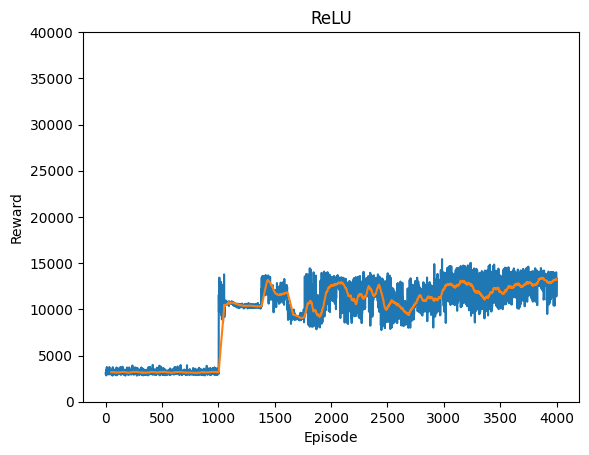

In [ ]:
plt.plot(tmp_df['episode'], tmp_df['reward'])
plt.plot(tmp_df['episode'], tmp_df['reward'].rolling(window=50).mean())
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title('ReLU')
plt.ylim(0, 40000)

In [ ]:
env = gym.make('HumanoidStandup-v5', render_mode="rgb_array", uph_cost_weight=1.2) # increasing the weight of the torso height in the reward function

In [ ]:
config['num_episodes'] = 3000
config['max_steps'] = 100
config['hidden_sizes'] = [512,512]
config['gamma'] = 0.995
config['nonlinearity'] = F.relu
config['warmup_steps'] = 30000

tmp_agent = SACAgent(state_dim, action_dim, action_bound, config)
tmp_tracker = MetricsTracker()
best_score = -float('inf')

train_model_intermediate_rewards(tmp_agent, tmp_tracker, best_score, f'/content/drive/MyDrive/CMPE260Data/intermediate_rewards_model.pth')
tmp_df = tmp_tracker.to_dataframe()
tmp_df.to_csv(f'/content/drive/MyDrive/CMPE260Data/intermediate_rewards_data.csv')


Starting training on cuda


  3%|▎         | 102/3000 [00:26<49:19,  1.02s/it]  

Ep 100 | Recent Avg: 3183.2 | Best Eval: 33405.8


  7%|▋         | 202/3000 [00:52<47:38,  1.02s/it]  

Ep 200 | Recent Avg: 3203.0 | Best Eval: 33405.8


 10%|█         | 300/3000 [01:16<52:57,  1.18s/it]

Ep 300 | Recent Avg: 3191.1 | Best Eval: 35103.7


 13%|█▎        | 400/3000 [03:41<2:53:17,  4.00s/it]

Ep 400 | Recent Avg: 9085.4 | Best Eval: 54050.6


 17%|█▋        | 500/3000 [06:05<2:34:53,  3.72s/it]

Ep 500 | Recent Avg: 10522.8 | Best Eval: 110138.6


 20%|██        | 600/3000 [08:30<2:28:50,  3.72s/it]

Ep 600 | Recent Avg: 11277.3 | Best Eval: 111190.3


 23%|██▎       | 700/3000 [10:52<2:19:10,  3.63s/it]

Ep 700 | Recent Avg: 10686.7 | Best Eval: 111190.3


 27%|██▋       | 800/3000 [13:14<2:11:14,  3.58s/it]

Ep 800 | Recent Avg: 10251.8 | Best Eval: 111190.3


 30%|███       | 900/3000 [15:38<2:26:08,  4.18s/it]

Ep 900 | Recent Avg: 10587.2 | Best Eval: 111190.3


 33%|███▎      | 1000/3000 [17:58<1:59:45,  3.59s/it]

Ep 1000 | Recent Avg: 10407.6 | Best Eval: 111190.3


 37%|███▋      | 1100/3000 [20:19<1:50:41,  3.50s/it]

Ep 1100 | Recent Avg: 11435.4 | Best Eval: 111190.3


 40%|████      | 1200/3000 [22:39<1:46:39,  3.56s/it]

Ep 1200 | Recent Avg: 11092.3 | Best Eval: 111190.3


 43%|████▎     | 1300/3000 [25:00<1:44:42,  3.70s/it]

Ep 1300 | Recent Avg: 10891.6 | Best Eval: 111190.3


 47%|████▋     | 1400/3000 [27:21<1:40:15,  3.76s/it]

Ep 1400 | Recent Avg: 10850.6 | Best Eval: 111190.3


 50%|█████     | 1500/3000 [29:41<1:31:18,  3.65s/it]

Ep 1500 | Recent Avg: 12542.1 | Best Eval: 111190.3


 53%|█████▎    | 1600/3000 [32:00<1:26:16,  3.70s/it]

Ep 1600 | Recent Avg: 7523.5 | Best Eval: 111190.3


 57%|█████▋    | 1700/3000 [34:18<1:18:14,  3.61s/it]

Ep 1700 | Recent Avg: 5349.5 | Best Eval: 111190.3


 60%|██████    | 1800/3000 [36:37<1:09:25,  3.47s/it]

Ep 1800 | Recent Avg: 5860.9 | Best Eval: 111190.3


 63%|██████▎   | 1900/3000 [38:55<1:05:41,  3.58s/it]

Ep 1900 | Recent Avg: 6652.2 | Best Eval: 111190.3


 67%|██████▋   | 2000/3000 [41:13<1:00:19,  3.62s/it]

Ep 2000 | Recent Avg: 7677.4 | Best Eval: 111190.3


 70%|███████   | 2100/3000 [43:31<55:06,  3.67s/it]

Ep 2100 | Recent Avg: 8219.1 | Best Eval: 111190.3


 73%|███████▎  | 2200/3000 [45:49<43:40,  3.28s/it]

Ep 2200 | Recent Avg: 9564.0 | Best Eval: 111190.3


 77%|███████▋  | 2300/3000 [48:07<46:24,  3.98s/it]

Ep 2300 | Recent Avg: 10131.9 | Best Eval: 111190.3


 80%|████████  | 2400/3000 [50:24<33:26,  3.34s/it]

Ep 2400 | Recent Avg: 9566.0 | Best Eval: 111190.3


 83%|████████▎ | 2500/3000 [52:42<29:50,  3.58s/it]

Ep 2500 | Recent Avg: 9542.1 | Best Eval: 111190.3


 87%|████████▋ | 2600/3000 [54:58<23:06,  3.47s/it]

Ep 2600 | Recent Avg: 11079.8 | Best Eval: 111190.3


 90%|█████████ | 2700/3000 [57:17<18:04,  3.61s/it]

Ep 2700 | Recent Avg: 10932.4 | Best Eval: 111190.3


 93%|█████████▎| 2800/3000 [59:34<13:06,  3.93s/it]

Ep 2800 | Recent Avg: 11359.6 | Best Eval: 111190.3


 97%|█████████▋| 2900/3000 [1:01:51<05:47,  3.48s/it]

Ep 2900 | Recent Avg: 11210.2 | Best Eval: 111190.3


100%|██████████| 3000/3000 [1:04:09<00:00,  1.28s/it]

Ep 3000 | Recent Avg: 11043.3 | Best Eval: 111190.3
Training Complete.


In [ ]:
def train_model_intermediate_rewards2(agent, tracker, best_score, save_path="sac_humanoid.pth"):
  print(f"Starting training on {device}")

  for i_episode in tqdm(range(1, config['num_episodes'] + 1)):

      # Run Training Episode
      state, _ = env.reset(seed=SEED + i_episode)
      score = 0
      step_count = 0
      done = False

      model = env.unwrapped.model
      torso_id = model.body('torso').id
      pelvis_id = model.body('pelvis').id
      right_thigh_id = model.body('right_thigh').id
      left_thigh_id = model.body('left_thigh').id
      right_foot_id = model.body('right_foot').id
      left_foot_id = model.body('left_foot').id


      while not done:
          step_count += 1

          if agent.total_steps < config['warmup_steps']:
              action = env.action_space.sample()
          else:
              action = agent.select_action(state)

          next_state, reward, term, trunc, _ = env.step(action)

          # calculate score before adding intermediate rewards
          score += reward

          #intermediate rewards
          data = env.unwrapped.data
          model = env.unwrapped.model

          # adding rewards if the z coordinate (height) of the body parts are in the correct order
          left_foot_z = data.xpos[left_foot_id][2]
          right_foot_z = data.xpos[right_foot_id][2]
          left_thigh_z = data.xpos[left_thigh_id][2]
          right_thigh_z = data.xpos[right_thigh_id][2]
          pelvis_z = data.xpos[pelvis_id][2]
          torso_z = data.xpos[torso_id][2]

          if right_thigh_z > right_foot_z:
            reward+= 10

          if left_thigh_z > left_foot_z:
            reward+= 10

          if pelvis_z > left_thigh_z:
            reward+= 10

          if pelvis_z > right_thigh_z:
            reward+= 10

          if torso_z > pelvis_z:
            reward+= 10

          done = term or trunc
          mask = 1 if trunc else float(not done)

          agent.buffer.store(state, action, next_state, reward, mask)
          agent.total_steps += 1

          if agent.total_steps >= config['warmup_steps']:
              losses = agent.update()
              if losses:
                  tracker.record_training(losses)

          state = next_state


          if step_count >= config['max_steps']:
              done = True

      # Record episode stats
      tracker.record_episode(score, step_count)

      # Evaluation Logic
      if i_episode % config['eval_frequency'] == 0:
          # unpack the tuple: (Mean, Std)
          avg_eval, std_eval = evaluate_agent(agent, 'HumanoidStandup-v5', num_episodes=config['eval_episodes'])

          tracker.record_evaluation(i_episode, avg_eval)

          if avg_eval > best_score:
              best_score = avg_eval
              agent.save("best_sac_humanoid.pth")

      # Logging
      if i_episode % 100 == 0:
          recent = tracker.get_recent_stats()
          print(f"Ep {i_episode} | Recent Avg: {recent['mean_reward']:.1f} | Best Eval: {best_score:.1f}")

  print("Training Complete.")
  agent.save(save_path)


In [ ]:
config['num_episodes'] = 2000
config['max_steps'] = 100
config['hidden_sizes'] = [512,512]
config['gamma'] = 0.995
config['nonlinearity'] = F.relu
config['warmup_steps'] = 30000

tmp_agent = SACAgent(state_dim, action_dim, action_bound, config)
tmp_tracker = MetricsTracker()
best_score = -float('inf')

train_model_intermediate_rewards2(tmp_agent, tmp_tracker, best_score, f'/content/drive/MyDrive/CMPE260Data/intermediate_rewards2_model.pth')
tmp_df = tmp_tracker.to_dataframe()
tmp_df.to_csv(f'/content/drive/MyDrive/CMPE260Data/intermediate_rewards2_data.csv')


Starting training on cpu


  5%|▌         | 102/2000 [00:29<50:58,  1.61s/it]  

Ep 100 | Recent Avg: 3173.6 | Best Eval: 55972.3


 10%|█         | 202/2000 [00:58<45:55,  1.53s/it]  

Ep 200 | Recent Avg: 3169.3 | Best Eval: 55972.3


 15%|█▌        | 300/2000 [01:27<1:12:17,  2.55s/it]

Ep 300 | Recent Avg: 3201.7 | Best Eval: 55972.3


 20%|██        | 400/2000 [19:32<6:09:10, 13.84s/it]

Ep 400 | Recent Avg: 8560.4 | Best Eval: 55972.3


 25%|██▌       | 500/2000 [37:50<5:45:29, 13.82s/it]

Ep 500 | Recent Avg: 10449.0 | Best Eval: 62185.2


 30%|███       | 600/2000 [55:54<5:32:38, 14.26s/it]

Ep 600 | Recent Avg: 10435.4 | Best Eval: 64814.5


 35%|███▌      | 700/2000 [1:14:12<4:59:17, 13.81s/it]

Ep 700 | Recent Avg: 11043.5 | Best Eval: 74701.0


 40%|████      | 800/2000 [1:32:30<4:50:03, 14.50s/it]

Ep 800 | Recent Avg: 11368.6 | Best Eval: 76656.6


 45%|████▌     | 900/2000 [1:51:31<4:30:47, 14.77s/it]

Ep 900 | Recent Avg: 11439.3 | Best Eval: 76656.6


 50%|█████     | 1000/2000 [2:11:11<4:26:40, 16.00s/it]

Ep 1000 | Recent Avg: 11142.4 | Best Eval: 76656.6


 55%|█████▌    | 1100/2000 [2:31:50<3:58:43, 15.92s/it]

Ep 1100 | Recent Avg: 10382.1 | Best Eval: 78580.1


 60%|██████    | 1200/2000 [2:52:34<3:30:15, 15.77s/it]

Ep 1200 | Recent Avg: 9632.7 | Best Eval: 78580.1


 65%|██████▌   | 1300/2000 [3:13:03<3:00:57, 15.51s/it]

Ep 1300 | Recent Avg: 9554.2 | Best Eval: 78580.1


 70%|███████   | 1400/2000 [3:33:39<2:34:19, 15.43s/it]

Ep 1400 | Recent Avg: 9456.9 | Best Eval: 78580.1


 75%|███████▌  | 1500/2000 [3:54:25<2:13:41, 16.04s/it]

Ep 1500 | Recent Avg: 9495.3 | Best Eval: 78580.1


 80%|████████  | 1600/2000 [4:15:10<1:44:53, 15.73s/it]

Ep 1600 | Recent Avg: 9237.1 | Best Eval: 78580.1


 85%|████████▌ | 1700/2000 [4:35:51<1:19:48, 15.96s/it]

Ep 1700 | Recent Avg: 10072.1 | Best Eval: 78580.1


 90%|█████████ | 1800/2000 [4:56:29<51:24, 15.42s/it]

Ep 1800 | Recent Avg: 10027.6 | Best Eval: 81166.3


 95%|█████████▌| 1900/2000 [5:17:24<26:11, 15.72s/it]

Ep 1900 | Recent Avg: 9931.1 | Best Eval: 81166.3


100%|██████████| 2000/2000 [5:38:22<00:00, 10.15s/it]

Ep 2000 | Recent Avg: 10029.7 | Best Eval: 81166.3
Training Complete.


In [ ]:
video_file = record_video_v5(tmp_agent)

if video_file:
    display(Video(video_file, embed=True, html_attributes="controls autoplay loop"))

Recording video to humanoid_v5_victory.mp4 using HumanoidStandup-v5
Video saved! (1000 frames, 1000 steps)


In [ ]:
def train_model_intermediate_rewards3(agent, tracker, best_score, save_path="sac_humanoid.pth"):
  print(f"Starting training on {device}")

  for i_episode in tqdm(range(1, config['num_episodes'] + 1)):

      # Run Training Episode
      state, _ = env.reset(seed=SEED + i_episode)
      score = 0
      step_count = 0
      done = False

      model = env.unwrapped.model
      torso_id = model.body('torso').id
      pelvis_id = model.body('pelvis').id
      right_thigh_id = model.body('right_thigh').id
      left_thigh_id = model.body('left_thigh').id
      right_foot_id = model.body('right_foot').id
      left_foot_id = model.body('left_foot').id


      while not done:
          step_count += 1

          if agent.total_steps < config['warmup_steps']:
              action = env.action_space.sample()
          else:
              action = agent.select_action(state)

          next_state, reward, term, trunc, _ = env.step(action)

          # calculate score before adding intermediate rewards
          score += reward

          #intermediate rewards
          data = env.unwrapped.data
          model = env.unwrapped.model


          left_foot_z = data.xpos[left_foot_id][2]
          right_foot_z = data.xpos[right_foot_id][2]
          left_thigh_z = data.xpos[left_thigh_id][2]
          right_thigh_z = data.xpos[right_thigh_id][2]
          pelvis_z = data.xpos[pelvis_id][2]
          torso_z = data.xpos[torso_id][2]

          # weighting the rewards given by the difference in z value between different body parts
          # EX: if the left thigh is higher than the left foot, an additional reward is added based on the magnitude of the difference of height

          if right_thigh_z > right_foot_z:
            reward+= 10 * (right_thigh_z-right_foot_z)

          if left_thigh_z > left_foot_z:
            reward+= 10 * (left_thigh_z-left_foot_z)

          if pelvis_z > left_thigh_z:
            reward+= 10 * (pelvis_z-left_thigh_z)

          if pelvis_z > right_thigh_z:
            reward+= 10 * (pelvis_z-right_thigh_z)

          if torso_z > pelvis_z:
            reward+= 10 * (torso_z-pelvis_z)

          done = term or trunc
          mask = 1 if trunc else float(not done)

          agent.buffer.store(state, action, next_state, reward, mask)
          agent.total_steps += 1

          if agent.total_steps >= config['warmup_steps']:
              losses = agent.update()
              if losses:
                  tracker.record_training(losses)

          state = next_state


          if step_count >= config['max_steps']:
              done = True

      # Record episode stats
      tracker.record_episode(score, step_count)

      # Evaluation Logic
      if i_episode % config['eval_frequency'] == 0:
          # unpack the tuple: (Mean, Std)
          avg_eval, std_eval = evaluate_agent(agent, 'HumanoidStandup-v5', num_episodes=config['eval_episodes'])

          tracker.record_evaluation(i_episode, avg_eval)

          if avg_eval > best_score:
              best_score = avg_eval
              agent.save("best_sac_humanoid.pth")

      # Logging
      if i_episode % 100 == 0:
          recent = tracker.get_recent_stats()
          print(f"Ep {i_episode} | Recent Avg: {recent['mean_reward']:.1f} | Best Eval: {best_score:.1f}")

  print("Training Complete.")
  agent.save(save_path)


In [ ]:
config['num_episodes'] = 3500
config['max_steps'] = 100
config['hidden_sizes'] = [512,512]
config['gamma'] = 0.995
config['nonlinearity'] = F.relu
config['warmup_steps'] = 30000

tmp_agent = SACAgent(state_dim, action_dim, action_bound, config)
tmp_tracker = MetricsTracker()
best_score = -float('inf')

train_model_intermediate_rewards3(tmp_agent, tmp_tracker, best_score, f'/content/drive/MyDrive/CMPE260Data/intermediate_rewards3_model.pth')
tmp_df = tmp_tracker.to_dataframe()
tmp_df.to_csv(f'/content/drive/MyDrive/CMPE260Data/intermediate_rewards3_data.csv')


Starting training on cpu


  3%|▎         | 102/3500 [00:36<1:07:20,  1.19s/it]

Ep 100 | Recent Avg: 3213.7 | Best Eval: 43468.8


  6%|▌         | 201/3500 [01:06<1:32:29,  1.68s/it]

Ep 200 | Recent Avg: 3189.9 | Best Eval: 43468.8


  9%|▊         | 300/3500 [01:35<2:09:05,  2.42s/it]

Ep 300 | Recent Avg: 3193.2 | Best Eval: 43468.8


 11%|█▏        | 400/3500 [19:32<11:57:40, 13.89s/it]

Ep 400 | Recent Avg: 9252.7 | Best Eval: 77997.6


 14%|█▍        | 500/3500 [37:57<12:04:34, 14.49s/it]

Ep 500 | Recent Avg: 11444.4 | Best Eval: 131333.3


 17%|█▋        | 600/3500 [56:03<11:12:50, 13.92s/it]

Ep 600 | Recent Avg: 10349.4 | Best Eval: 131333.3


 19%|█▉        | 675/3500 [1:09:34<8:22:41, 10.68s/it]

In [ ]:
video_file = record_video_v5(tmp_agent)

if video_file:
    display(Video(video_file, embed=True, html_attributes="controls autoplay loop"))